In [3]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.datasets import get_x_y
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)

import optuna

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

import gseapy as gp

# Clinical

In [4]:
clinical_sample = pd.read_csv("/Users/viktornekrasov/project_cba/all_phase2_target_2018_pub/data_clinical_sample.txt", sep='\t', skiprows=4)
clinical_sample = clinical_sample.replace({"Yes":1, "No":0, "Positive":1, "Negative":0, "Unknown":np.nan})

/var/folders/hs/l1mql9g113j05nftmscx4c4w0000gn/T/ipykernel_86585/2997179256.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_sample = clinical_sample.replace({"Yes":1, "No":0, "Positive":1, "Negative":0, "Unknown":np.nan})


## Patient

In [338]:
clinical_patient = pd.read_csv("/Users/viktornekrasov/project_cba/all_phase2_target_2018_pub/data_clinical_patient.txt", sep='\t', skiprows=4).replace({"Yes":1, "No":0, "Positive":1, "Negative":0, "Unknown":np.nan, "1:DECEASED":1, "0:LIVING":0})

drop:
MRD_PERCENT_DAY_8
MRD_PERCENT_DAY_8_SENSITIVITY
MRD_PERCENT_DAY_43
MRD_PERCENT_DAY_43_SENSITIVITY
MRD_END_CONSOLIDATION
MRD_END_CONSOLIDATION_SENSITIVITY
FIRST_EVENT
DAYS_TO_EVENT
OS_MONTHS
DAYS_TO_DEATH
BM_DAY_43
KARYOTYPE
ALTERNATE_THERAPY
ALTERNATE_THERAPY_OTHER

In [339]:
columns_to_drop_patient = ['AGE', 'CONGENITAL_ABNORMALITY', 'TESTICULAR_INVOLVEMENT', 'MRD_PERCENT_DAY_8', 'MRD_PERCENT_DAY_8_SENSITIVITY', 'MRD_PERCENT_DAY_43', 'MRD_PERCENT_DAY_43_SENSITIVITY', 'MRD_END_CONSOLIDATION', 'MRD_END_CONSOLIDATION_SENSITIVITY', 'FIRST_EVENT', 'DAYS_TO_EVENT', 'OS_MONTHS', 'DAYS_TO_DEATH', 'BM_DAY_43', 'KARYOTYPE', 'ALTERNATE_THERAPY', 'ALTERNATE_THERAPY_OTHER']
clinical_patient.drop(columns=columns_to_drop_patient, axis=1, inplace=True)

In [340]:
clinical_patient.dropna(thresh=3, axis=0, inplace=True)

In [341]:
protocols_to_drop = ['9906', 'AALL0031', 'AALL1131']
patients_to_drop = clinical_patient.loc[clinical_patient['PROTOCOL'].astype(str).isin(protocols_to_drop), 'PATIENT_ID'].dropna().unique()

clinical_patient = clinical_patient.loc[~clinical_patient['PATIENT_ID'].isin(patients_to_drop)].reset_index(drop=True)

In [342]:
def map_cns(x):
    if pd.isna(x) or x == ".":
        return "Missing"
    if x.startswith("CNS 1"):
        return "CNS_1"
    if x.startswith("CNS 2"):
        return "CNS_2"
    if x.startswith("CNS 3"):
        return "CNS_3"
    return "Other"

clinical_patient["CNS_GROUP"] = clinical_patient["CNS_STATUS"].apply(map_cns)
clinical_patient["CNS_GROUP"].value_counts()

CNS_GROUP
CNS_1      1245
CNS_2       236
CNS_3        43
Missing       1
Name: count, dtype: int64

In [343]:
def one_hot_encode_non_float(df, exclude=None, drop_first=False, prefix_sep='_', verbose=False):
    """One-hot encode columns whose dtype is not float.

    For columns that have exactly 2 unique values (after NA->'NA'), this will encode them as a single dummy column (drop one level) to avoid redundant features.

    Parameters:
        df (pd.DataFrame): input dataframe
        exclude (list): columns to exclude from encoding
        drop_first (bool): whether to drop the first level for multi-category columns
        prefix_sep (str): separator used by pd.get_dummies for prefixes
        verbose (bool): whether to print info about encoded columns
    Returns:
        pd.DataFrame: DataFrame with non-float columns replaced by one-hot encoded columns
    """
    exclude = set(exclude or [])
    cols_to_encode = [c for c in df.columns if c not in exclude and not pd.api.types.is_float_dtype(df[c])]
    if not cols_to_encode:
        return df.copy()

    df_encoded = df.copy()
    df_encoded[cols_to_encode] = df_encoded[cols_to_encode].fillna('NA').astype(str)

    binary_cols = [c for c in cols_to_encode if df_encoded[c].nunique(dropna=False) == 2]
    multi_cols = [c for c in cols_to_encode if c not in binary_cols]

    parts = []
    if binary_cols:
        if verbose:
            print('Binary columns (single dummy will be created):', binary_cols)
        d_bin = pd.get_dummies(df_encoded[binary_cols], prefix=binary_cols, prefix_sep=prefix_sep, drop_first=True, dtype=int)
        parts.append(d_bin)
    if multi_cols:
        if verbose:
            print('Multi-category columns (one-hot encoded):', multi_cols)
        d_mul = pd.get_dummies(df_encoded[multi_cols], prefix=multi_cols, prefix_sep=prefix_sep, drop_first=drop_first, dtype=int)
        parts.append(d_mul)

    dummies = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=df_encoded.index)
    df_encoded = pd.concat([df_encoded.drop(columns=cols_to_encode), dummies], axis=1)
    return df_encoded

clinical_patient_ohe = one_hot_encode_non_float(clinical_patient.drop("CNS_STATUS", axis=1), exclude=['PATIENT_ID', 'OS_DAYS', 'OS_STATUS'], verbose=True)

Binary columns (single dummy will be created): ['SEX']
Multi-category columns (one-hot encoded): ['RACE', 'ETHNICITY', 'PROTOCOL', 'CNS_GROUP']


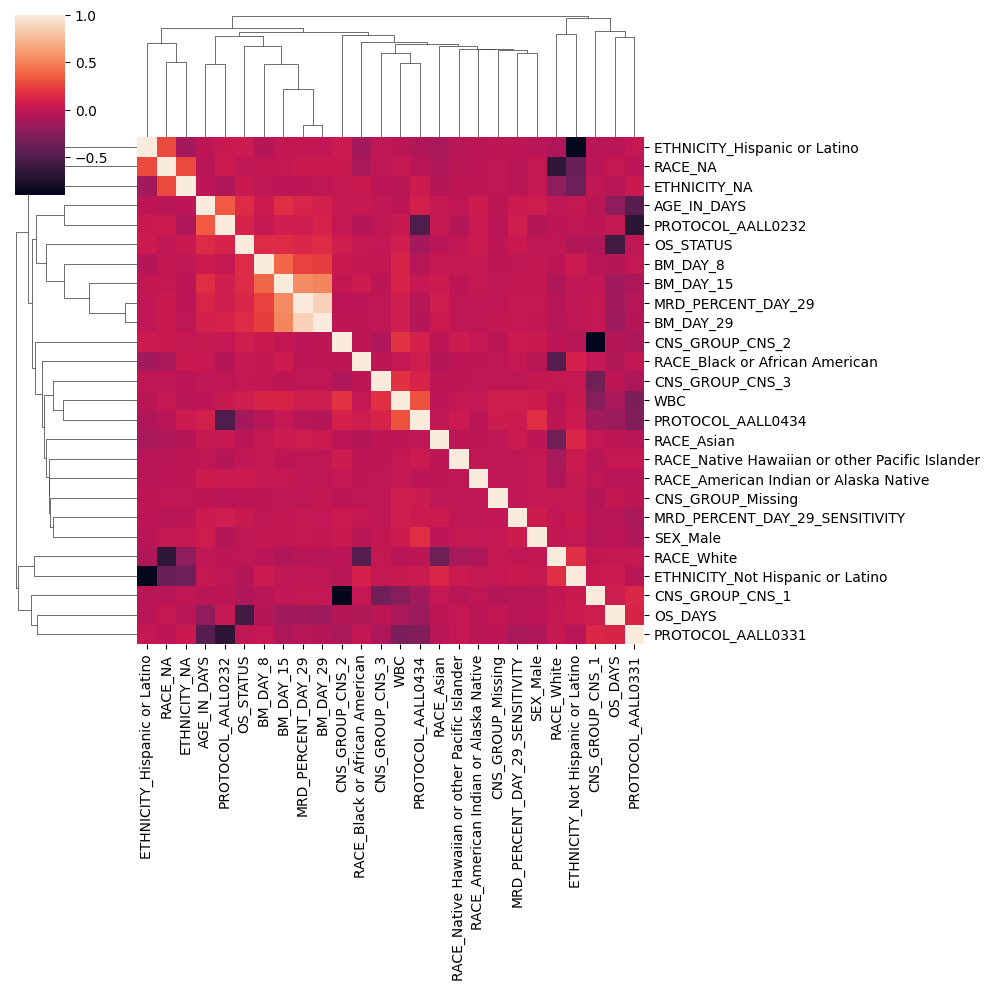

In [344]:
sns.clustermap(clinical_patient_ohe.corr(numeric_only=True).replace(np.nan, 0), annot=False)

In [345]:
clinical_patient_ohe["BM_DAY_15_missing"] = clinical_patient_ohe["BM_DAY_15"].isna().astype(int)
clinical_patient_ohe["BM_DAY_15"] = clinical_patient_ohe["BM_DAY_15"].fillna(clinical_patient_ohe["BM_DAY_15"].median())

In [346]:
clinical_patient_ohe.dropna(axis=0, inplace=True)

In [347]:
clinical_patient_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 0 to 1524
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   PATIENT_ID                                      1313 non-null   object 
 1   AGE_IN_DAYS                                     1313 non-null   float64
 2   WBC                                             1313 non-null   float64
 3   MRD_PERCENT_DAY_29                              1313 non-null   float64
 4   MRD_PERCENT_DAY_29_SENSITIVITY                  1313 non-null   float64
 5   OS_STATUS                                       1313 non-null   float64
 6   OS_DAYS                                         1313 non-null   float64
 7   BM_DAY_8                                        1313 non-null   float64
 8   BM_DAY_15                                       1313 non-null   float64
 9   BM_DAY_29                                     

In [348]:
clinical_patient_ohe.drop(["RACE_NA", "ETHNICITY_NA", "CNS_GROUP_Missing", "BM_DAY_29", "ETHNICITY_Not Hispanic or Latino", 'MRD_PERCENT_DAY_29_SENSITIVITY', 'MRD_PERCENT_DAY_29'], axis=1, inplace=True)

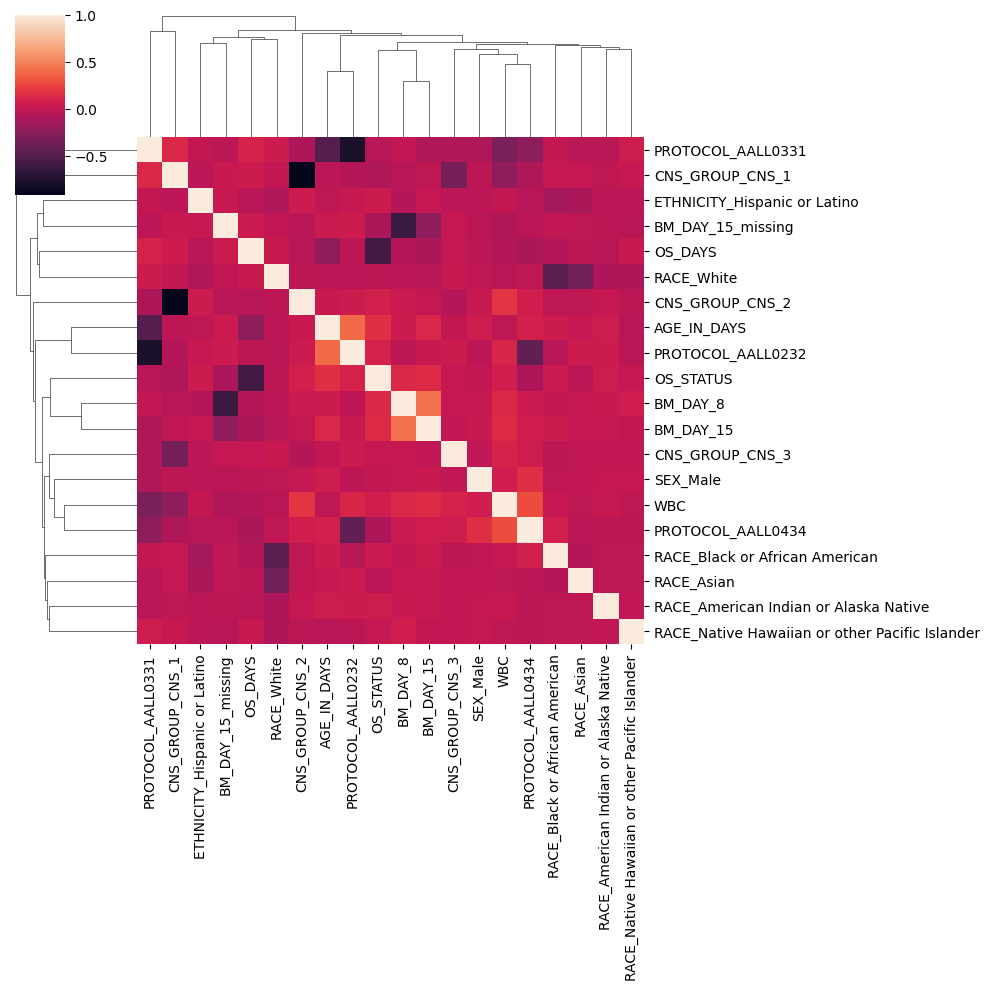

In [350]:
sns.clustermap(clinical_patient_ohe.corr(numeric_only=True).replace(np.nan, 0), annot=False)

In [351]:
def drop_redundant_ohe(df, sep="_", strategy="most_frequent"):
    """Drop one dummy column per one-hot group (columns like PREFIX_value).
    Strategy: 'most_frequent' drops the member with highest mean (most common).
    Returns: (df_reduced, dropped_columns)
    """

    cols = df.columns.tolist()
    bin_cols = [c for c in cols if df[c].dropna().isin([0, 1]).all()]

    groups = {}
    for c in bin_cols:
        if sep in c:
            prefix = c.split(sep, 1)[0]
            groups.setdefault(prefix, []).append(c)

    drop_cols = []
    for prefix, members in groups.items():
        if len(members) <= 1:
            continue

        s = df.loc[:, members].sum(axis=1)
        if (s > 1).sum() > len(df) * 0.05:
            continue
        
        if strategy == "most_frequent":
            drop = df[members].mean().idxmax()
        elif strategy == "least_frequent":
            drop = df[members].mean().idxmin()
        else:
            drop = sorted(members)[0]
        drop_cols.append(drop)

    df_reduced = df.drop(columns=drop_cols)
    return df_reduced, drop_cols


clinical_patient_ohe, dropped = drop_redundant_ohe(clinical_patient_ohe, sep="_", strategy="most_frequent")
print(f"Dropped {len(dropped)} columns:", dropped)

Dropped 3 columns: ['RACE_White', 'PROTOCOL_AALL0232', 'CNS_GROUP_CNS_1']


## Sample

In [87]:
clinical_sample

,PATIENT_ID,SAMPLE_ID,BONE_MARROW_SITE_OF_RELAPSE,CNS_SITE_OF_RELAPSE,TESTES_SITE_OF_RELAPSE,OTHER_SITE_OF_RELAPSE,ETV6_RUNX1_FUSION_STATUS,TRISOMY_4_10,MLL_STATUS,BCR_ABL1_STATUS,TCF3_PBX1_STATUS,DNA_INDEX,CELL_OF_ORIGIN,MOLECULAR_SUBTYPE,ONCOTREE_CODE,ANALYSIS_COHORT,CANCER_TYPE,CANCER_TYPE_DETAILED,SOMATIC_STATUS,TMB_NONSYNONYMOUS
0,TARGET-10-PANBXW,TARGET-10-PANBXW-09,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0000,B-Precursor,ETV6-RUNX1,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1,TARGET-10-PANCVR,TARGET-10-PANCVR-03,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0000,B-Precursor,None of the above,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,0.1
2,TARGET-10-PANCVR,TARGET-10-PANCVR-04,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0000,B-Precursor,None of the above,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
3,TARGET-10-PANCVR,TARGET-10-PANCVR-09,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0000,B-Precursor,None of the above,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
4,TARGET-10-PANDCF,TARGET-10-PANDCF-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1600,B-Precursor,Hyperdiploidy without trisomy of both chromsom...,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,TARGET-10-PARBDN,TARGET-10-PARBDN-09,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0000,B-Precursor,ETV6-RUNX1,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1974,TARGET-10-PARNFY,TARGET-10-PARNFY-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0000,B-Precursor,TCF3-PBX1,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1975,TARGET-10-PARPRD,TARGET-10-PARPRD-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0000,B-Precursor,None of the above,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1976,TARGET-10-PARSRH,TARGET-10-PARSRH-09,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0692,B-Precursor,MLL-Rearranged,BLL,DISCOVERY,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN


In [ ]:
clinical_sample['_nan_count'] = clinical_sample.isna().sum(axis=1)
idx = clinical_sample.groupby('PATIENT_ID')['_nan_count'].idxmin()
clinical_sample_one_per_patient = clinical_sample.loc[idx].drop(columns=['_nan_count']).reset_index(drop=True)

In [89]:
clinical_sample_one_per_patient

,PATIENT_ID,SAMPLE_ID,BONE_MARROW_SITE_OF_RELAPSE,CNS_SITE_OF_RELAPSE,TESTES_SITE_OF_RELAPSE,OTHER_SITE_OF_RELAPSE,ETV6_RUNX1_FUSION_STATUS,TRISOMY_4_10,MLL_STATUS,BCR_ABL1_STATUS,TCF3_PBX1_STATUS,DNA_INDEX,CELL_OF_ORIGIN,MOLECULAR_SUBTYPE,ONCOTREE_CODE,ANALYSIS_COHORT,CANCER_TYPE,CANCER_TYPE_DETAILED,SOMATIC_STATUS,TMB_NONSYNONYMOUS
0,TARGET-10-CAAABC,TARGET-10-CAAABC-60.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T Cell ALL,NaN,BLL,XENOGRAFT,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1,TARGET-10-CAAABD,TARGET-10-CAAABD-60.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T Cell ALL,NaN,BLL,XENOGRAFT,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
2,TARGET-10-CAAABF,TARGET-10-CAAABF-60.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T Cell ALL,NaN,BLL,XENOGRAFT,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
3,TARGET-10-PAKHZT,TARGET-10-PAKHZT-60.11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,B Cell ALL,None of above,BLL,XENOGRAFT,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
4,TARGET-10-PAKKCA,TARGET-10-PAKKCA-60.1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,B Cell ALL,None of above,BLL,XENOGRAFT,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,TARGET-10-PAUBTC,TARGET-10-PAUBTC-09,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,1.114,T Cell ALL,NaN,BLL,VALIDATION,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1547,TARGET-10-PAUBXP,TARGET-10-PAUBXP-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,T Cell ALL,NaN,BLL,VALIDATION,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1548,TARGET-10-PAUCDC,TARGET-10-PAUCDC-09,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.000,T Cell ALL,NaN,BLL,VALIDATION,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN
1549,TARGET-10-PAUCDY,TARGET-10-PAUCDY-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,T Cell ALL,NaN,BLL,VALIDATION,B-Lymphoblastic Leukemia/Lymphoma,B-Lymphoblastic Leukemia/Lymphoma,Matched,NaN


In [ ]:
clinical_sample_one_per_patient = clinical_sample_one_per_patient.merge(
    clinical_patient[['PATIENT_ID', 'OS_DAYS', 'OS_STATUS']].rename(columns={'OS_STATUS': 'OS_EVENT'}),
    on='PATIENT_ID',
    how='left'
)

clinical_sample_one_per_patient['OS_EVENT'] = clinical_sample_one_per_patient['OS_EVENT'].replace(
    {'1:DECEASED': 1, '0:LIVING': 0}
).astype(float)

clinical_sample_one_per_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PATIENT_ID                   1551 non-null   object 
 1   SAMPLE_ID                    1551 non-null   object 
 2   BONE_MARROW_SITE_OF_RELAPSE  1544 non-null   float64
 3   CNS_SITE_OF_RELAPSE          1544 non-null   float64
 4   TESTES_SITE_OF_RELAPSE       1544 non-null   float64
 5   OTHER_SITE_OF_RELAPSE        1544 non-null   float64
 6   ETV6_RUNX1_FUSION_STATUS     1111 non-null   float64
 7   TRISOMY_4_10                 1183 non-null   float64
 8   MLL_STATUS                   1158 non-null   float64
 9   BCR_ABL1_STATUS              1541 non-null   float64
 10  TCF3_PBX1_STATUS             1044 non-null   float64
 11  DNA_INDEX                    1537 non-null   float64
 12  CELL_OF_ORIGIN               1547 non-null   object 
 13  MOLECULAR_SUBTYPE 

In [91]:
clinical_sample_one_per_patient.drop("ANALYSIS_COHORT", axis=1, inplace=True)

In [ ]:
exclude = ['PATIENT_ID', 'SAMPLE_ID', 'OS_DAYS', 'OS_EVENT']
cols_to_encode = [c for c in clinical_sample_one_per_patient.columns if c not in exclude and not pd.api.types.is_float_dtype(clinical_sample_one_per_patient[c])]

df = clinical_sample_one_per_patient.copy()
df[cols_to_encode] = df[cols_to_encode].fillna('NA').astype(str)

dummies = pd.get_dummies(df[cols_to_encode], prefix=cols_to_encode, prefix_sep='_', dtype=int)
clinical_sample_one_per_patient_ohe = pd.concat([df.drop(columns=cols_to_encode), dummies], axis=1)

drop_cols = []
for col in cols_to_encode:
    members = sorted([c for c in clinical_sample_one_per_patient_ohe.columns if c.startswith(col + '_')])
    if not members:
        continue
    na_members = [m for m in members if m.endswith('_NA')]
    if na_members:
        drop_cols.append(na_members[0])
    else:
        drop_cols.append(members[-1])

drop_cols = [c for c in drop_cols if c in clinical_sample_one_per_patient_ohe.columns]
clinical_sample_one_per_patient_ohe.drop(columns=drop_cols, inplace=True)

print("Original shape:", clinical_sample_one_per_patient.shape)
print("Encoded shape :", clinical_sample_one_per_patient_ohe.shape)
print("Dropped columns:", drop_cols)

Original shape: (1551, 21)
Encoded shape : (1551, 31)
Dropped columns: ['CELL_OF_ORIGIN_NA', 'MOLECULAR_SUBTYPE_NA', 'ONCOTREE_CODE_BLL', 'CANCER_TYPE_DETAILED_B-Lymphoblastic Leukemia/Lymphoma', 'CANCER_TYPE_DETAILED_B-Lymphoblastic Leukemia/Lymphoma', 'SOMATIC_STATUS_Matched']


In [ ]:
clinical_sample_one_per_patient_ohe.drop(["MOLECULAR_SUBTYPE_BCR-ABL1", "MOLECULAR_SUBTYPE_TCF3-PBX1", "MOLECULAR_SUBTYPE_ETV6-RUNX1", "TRISOMY_4_10", "MOLECULAR_SUBTYPE_MLL-Rearranged", "TMB_NONSYNONYMOUS", "CANCER_TYPE_B-Lymphoblastic Leukemia/Lymphoma"], axis=1)

## Patient and sample

In [ ]:
patient_feats = clinical_patient_ohe.set_index("PATIENT_ID").drop(columns=["OS_DAYS", "OS_STATUS"], errors="ignore").add_suffix("_patient").reset_index()
sample_base = clinical_sample_one_per_patient_ohe.drop(columns=["OS_DAYS", "OS_EVENT"], errors="ignore")

combined_ohe = sample_base.merge(patient_feats, on="PATIENT_ID", how="left")
combined_ohe = combined_ohe.merge(clinical_patient_ohe[["PATIENT_ID", "OS_DAYS", "OS_STATUS"]], on="PATIENT_ID", how="left")

combined_ohe["OS_STATUS"] = combined_ohe["OS_STATUS"].replace({"1:DECEASED": 1, "0:LIVING": 0}).astype(float)
combined_ohe = combined_ohe.dropna(subset=["OS_DAYS", "OS_STATUS"]).reset_index(drop=True)

print("Combined shape:", combined_ohe.shape)
combined_ohe.info()

Combined shape: (1313, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 39 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   PATIENT_ID                                                                   1313 non-null   object 
 1   SAMPLE_ID                                                                    1313 non-null   object 
 2   BONE_MARROW_SITE_OF_RELAPSE                                                  1313 non-null   float64
 3   CNS_SITE_OF_RELAPSE                                                          1313 non-null   float64
 4   TESTES_SITE_OF_RELAPSE                                                       1313 non-null   float64
 5   OTHER_SITE_OF_RELAPSE                                                        1313 non-null   float64
 6   ETV6_RUNX1_FU

In [104]:
df_train, df_test = train_test_split(combined_ohe.dropna(axis=0), test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

In [107]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0)

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph.fit(df_train.drop(["MOLECULAR_SUBTYPE_TCF3-HLF", "OTHER_SITE_OF_RELAPSE", "MOLECULAR_SUBTYPE_Hyperdiploid; status of 4 and 10 unknown", "MOLECULAR_SUBTYPE_None of above"], axis=1).drop(columns=["PATIENT_ID", "SAMPLE_ID"]), duration_col="OS_DAYS", event_col="OS_STATUS", show_progress=False)

    score = cph.score(df_val, scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 03:38:30,297] A new study created in memory with name: no-name-faeb1599-c818-4944-a657-84f94683db32
[I 2025-12-18 03:38:33,551] Trial 0 finished with value: 0.8282918149466192 and parameters: {'penalizer': 5.6593003686905154, 'l1_ratio': 0.48113334214024683}. Best is trial 0 with value: 0.8282918149466192.
[I 2025-12-18 03:38:33,768] Trial 7 finished with value: 0.8282918149466192 and parameters: {'penalizer': 4.811043255681696, 'l1_ratio': 0.24908797866406857}. Best is trial 0 with value: 0.8282918149466192.
[I 2025-12-18 03:38:34,060] Trial 4 finished with value: 0.8540925266903915 and parameters: {'penalizer': 0.0655645328978914, 'l1_ratio': 0.1173993507380299}. Best is trial 4 with value: 0.8540925266903915.
[I 2025-12-18 03:38:34,157] Trial 5 finished with value: 0.8620996441281139 and parameters: {'penalizer': 0.027116109163410743, 'l1_ratio': 0.5226189973092655}. Best is trial 5 with value: 0.8620996441281139.
[I 2025-12-18 03:38:34,263] Trial 2 finished with value

Best params: {'penalizer': 0.0642393344545747, 'l1_ratio': 0.9419509330735021}
Best c-index: 0.8861209964412812


In [110]:
cph = CoxPHFitter(penalizer=0.0642393344545747, l1_ratio=0.9419509330735021)
cph.fit(df_train.drop(["MOLECULAR_SUBTYPE_TCF3-HLF", "OTHER_SITE_OF_RELAPSE", "MOLECULAR_SUBTYPE_Hyperdiploid; status of 4 and 10 unknown", "MOLECULAR_SUBTYPE_None of above"], axis=1).drop(columns=["PATIENT_ID", "SAMPLE_ID"]), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 462 total observations, 373 right-censored observations>

In [111]:
print(cph.score(df_train.drop(["MOLECULAR_SUBTYPE_TCF3-HLF", "OTHER_SITE_OF_RELAPSE", "MOLECULAR_SUBTYPE_Hyperdiploid; status of 4 and 10 unknown", "MOLECULAR_SUBTYPE_None of above"], axis=1).drop(columns=["PATIENT_ID", "SAMPLE_ID"]), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["MOLECULAR_SUBTYPE_TCF3-HLF", "OTHER_SITE_OF_RELAPSE", "MOLECULAR_SUBTYPE_Hyperdiploid; status of 4 and 10 unknown", "MOLECULAR_SUBTYPE_None of above"], axis=1).drop(columns=["PATIENT_ID", "SAMPLE_ID"]), scoring_method="concordance_index"))

0.8325372702272398
0.9026442307692307


In [113]:
cph.summary.sort_values(by="p", ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
BONE_MARROW_SITE_OF_RELAPSE,1.798136e+00,6.038383,2.214527e-01,1.364097,2.232176,3.912188,9.320121,0.0,8.119729,4.672249e-16,50.926732
AGE_IN_DAYS_patient,4.080977e-05,1.000041,5.661486e-05,-0.000070,0.000152,0.999930,1.000152,0.0,0.720831,4.710133e-01,1.086160
DNA_INDEX,-4.906448e-01,0.612232,1.066077e+00,-2.580117,1.598828,0.075765,4.947230,0.0,-0.460234,6.453484e-01,0.631850
ETV6_RUNX1_FUSION_STATUS,-9.716248e-02,0.907409,3.102824e-01,-0.705305,0.510980,0.493958,1.666924,0.0,-0.313142,7.541727e-01,0.407033
MOLECULAR_SUBTYPE_None of the above,4.077034e-02,1.041613,2.594930e-01,-0.467827,0.549367,0.626362,1.732157,0.0,0.157115,8.751539e-01,0.192391
CELL_OF_ORIGIN_B-Precursor,1.750714e-07,1.000000,1.792194e-04,-0.000351,0.000351,0.999649,1.000352,0.0,0.000977,9.992206e-01,0.001125
MOLECULAR_SUBTYPE_Hypodiploid,1.127018e-06,1.000001,1.189868e-03,-0.002331,0.002333,0.997672,1.002336,0.0,0.000947,9.992443e-01,0.001091
WBC_patient,8.276004e-10,1.000000,8.772735e-07,-0.000002,0.000002,0.999998,1.000002,0.0,0.000943,9.992473e-01,0.001086
CELL_OF_ORIGIN_B Cell ALL,-1.451898e-07,1.000000,1.545782e-04,-0.000303,0.000303,0.999697,1.000303,0.0,-0.000939,9.992506e-01,0.001082


In [114]:
df_train, df_test = train_test_split(clinical_sample_one_per_patient.loc[:, ["BONE_MARROW_SITE_OF_RELAPSE", "OS_DAYS", "OS_EVENT"]].dropna(axis=0), test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

In [115]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col = "OS_DAYS", event_col = "OS_EVENT")

print(cph.score(df_train, scoring_method="concordance_index"))
print(cph.score(df_test, scoring_method="concordance_index"))

cph.summary.sort_values(by="p", ascending=True) 

0.762343321521143
0.8341423948220065


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
BONE_MARROW_SITE_OF_RELAPSE,2.56207,12.962628,0.162337,2.243896,2.880244,9.430004,17.818628,0.0,15.782454,4.109004e-56,183.989185


## RSF

In [ ]:
sample = clinical_sample_one_per_patient.copy()
if 'OS_EVENT' in sample.columns:
    sample = sample.drop(columns=['OS_EVENT'])

merged = sample.merge(clinical_patient, on='PATIENT_ID', how='inner', suffixes=('_sample', '_patient'))
print("Merged shape:", merged.shape)

miss_frac = merged.isna().mean()
to_drop_missing = miss_frac[miss_frac > 0.30].index.tolist()
print("Dropping columns with >30% missing (count={}): {}".format(len(to_drop_missing), to_drop_missing))
merged = merged.drop(columns=to_drop_missing)

exclude = ['PATIENT_ID', 'SAMPLE_ID', 'OS_DAYS', 'OS_STATUS']
merged_ohe = one_hot_encode_non_float(merged, exclude=exclude, drop_first=False, verbose=True)

na_like = [c for c in merged_ohe.columns if c.endswith('_NA') or c.endswith('_Missing') or c.endswith('_Unknown') or '_NA' in c or '_Missing' in c or '_Unknown' in c]
print("Removing NA/Unknown dummies (count={}): {}".format(len(na_like), na_like))
merged_ohe.drop(columns=na_like, errors='ignore', inplace=True)

binary_cols = [c for c in merged_ohe.columns if merged_ohe[c].dropna().isin([0, 1]).all() and c not in exclude + ['PATIENT_ID', 'SAMPLE_ID']]
rare = [c for c in binary_cols if merged_ohe[c].mean() < 0.01]
print("Removing very rare dummies (count={}): {}".format(len(rare), rare))
merged_ohe.drop(columns=rare, inplace=True)

merged_ohe, dropped_by_group = drop_redundant_ohe(merged_ohe, sep="_", strategy="most_frequent")
print("Dropped by group (count={}): {}".format(len(dropped_by_group), dropped_by_group))

zero_var = [c for c in merged_ohe.select_dtypes(include=[np.number]).columns if merged_ohe[c].std() == 0]
if zero_var:
    print("Dropping zero-variance columns:", zero_var)
    merged_ohe.drop(columns=zero_var, inplace=True)

print("Final shape:", merged_ohe.shape)

Merged shape: (1525, 35)
Dropping columns with >30% missing (count=4): ['TCF3_PBX1_STATUS', 'MOLECULAR_SUBTYPE', 'TMB_NONSYNONYMOUS', 'BM_DAY_15']
Binary columns (single dummy will be created): ['SEX']
Multi-category columns (one-hot encoded): ['CELL_OF_ORIGIN', 'ONCOTREE_CODE', 'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'SOMATIC_STATUS', 'RACE', 'ETHNICITY', 'CNS_STATUS', 'PROTOCOL', 'CNS_GROUP']
Removing NA/Unknown dummies (count=3): ['RACE_NA', 'ETHNICITY_NA', 'CNS_GROUP_Missing']
Removing very rare dummies (count=7): ['TESTES_SITE_OF_RELAPSE', 'RACE_American Indian or Alaska Native', 'RACE_Native Hawaiian or other Pacific Islander', 'CNS_STATUS_.', 'CNS_STATUS_CNS 3a', 'CNS_STATUS_CNS 3b', 'CNS_STATUS_CNS 3c']
Dropped by group (count=4): ['CELL_OF_ORIGIN_B-Precursor', 'RACE_White', 'ETHNICITY_Not Hispanic or Latino', 'PROTOCOL_AALL0232']
Dropping zero-variance columns: ['ONCOTREE_CODE_BLL', 'CANCER_TYPE_B-Lymphoblastic Leukemia/Lymphoma', 'CANCER_TYPE_DETAILED_B-Lymphoblastic Leukemia/

In [47]:
merged_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PATIENT_ID                      1525 non-null   object 
 1   SAMPLE_ID                       1525 non-null   object 
 2   BONE_MARROW_SITE_OF_RELAPSE     1525 non-null   float64
 3   CNS_SITE_OF_RELAPSE             1525 non-null   float64
 4   OTHER_SITE_OF_RELAPSE           1525 non-null   float64
 5   ETV6_RUNX1_FUSION_STATUS        1092 non-null   float64
 6   TRISOMY_4_10                    1165 non-null   float64
 7   MLL_STATUS                      1139 non-null   float64
 8   BCR_ABL1_STATUS                 1522 non-null   float64
 9   DNA_INDEX                       1518 non-null   float64
 10  OS_DAYS_sample                  1516 non-null   float64
 11  AGE_IN_DAYS                     1525 non-null   float64
 12  WBC                             15

In [48]:
df_train, df_test = train_test_split(merged_ohe.drop("OS_DAYS_patient", axis=1).dropna(subset=["OS_DAYS_sample", "OS_STATUS"]), test_size=0.2, shuffle = True, random_state=42)

In [49]:
X_df_train, y_df_train = get_x_y(df_train, ["OS_STATUS", "OS_DAYS_sample"], 1)
X_df_test, y_df_test = get_x_y(df_test, ["OS_STATUS", "OS_DAYS_sample"], 1)

X_df_train = X_df_train.drop(["PATIENT_ID", "SAMPLE_ID"],  axis = 1)
X_df_test = X_df_test.drop(["PATIENT_ID", "SAMPLE_ID"],  axis = 1)

In [129]:
%%time

rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=20,
                           n_jobs=-1,
                           random_state=123)
rsf.fit(X_df_train, y_df_train)

CPU times: user 10.9 s, sys: 311 ms, total: 11.3 s
Wall time: 2.01 s


RandomSurvivalForest(min_samples_leaf=20, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=123)

In [ ]:
from sklearn.inspection import permutation_importance

result_rsf = permutation_importance(
    rsf, X_df_test, y_df_test, n_repeats=5, random_state=123, n_jobs=-1
)

In [132]:
print(rsf.score(X_df_train, y_df_train))
print(rsf.score(X_df_test, y_df_test))

0.8997569446291145
0.8772509848058525


In [ ]:
pd.DataFrame(
    {k: result_rsf[k] for k in ("importances_mean", "importances_std",)},
    index=X_df_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
BONE_MARROW_SITE_OF_RELAPSE,1.616840e-01,0.028665
MRD_PERCENT_DAY_29,2.015335e-02,0.000598
ETV6_RUNX1_FUSION_STATUS,1.143078e-02,0.002990
AGE_IN_DAYS,1.062183e-02,0.003376
CNS_SITE_OF_RELAPSE,7.808104e-03,0.000211
ANALYSIS_COHORT_VALIDATION,4.924029e-03,0.004080
WBC,4.783343e-03,0.001125
BM_DAY_8,3.024761e-03,0.001266
DNA_INDEX,2.180642e-03,0.002603
BCR_ABL1_STATUS,1.125492e-03,0.000914


# RNA seq

In [201]:
rna_seq = pd.read_csv("/Users/viktornekrasov/project_cba/all_phase2_target_2018_pub/data_mrna_seq_rpkm.txt", sep="\t", skiprows=0)

In [202]:
clinical_samples_with_rnaseq = clinical_sample[clinical_sample["SAMPLE_ID"].isin(list(rna_seq)[2:])]
clinical_samples_with_rnaseq["PATIENT_ID"].nunique()

154

In [203]:
samples_list = clinical_samples_with_rnaseq.groupby("PATIENT_ID")["SAMPLE_ID"].first().tolist()
rna_seq = rna_seq.loc[:, ["Hugo_Symbol", "Entrez_Gene_Id"] + samples_list]

In [204]:
duplicate_count = rna_seq['Entrez_Gene_Id'].duplicated().sum()

print(f"Number of duplicate Entrez_Gene_Id values: {duplicate_count}")

if duplicate_count > 0:
    print("\nDuplicate Entrez_Gene_Id values:")
    print(rna_seq[rna_seq['Entrez_Gene_Id'].duplicated(keep=False)].sort_values('Entrez_Gene_Id')[['Hugo_Symbol', 'Entrez_Gene_Id']])

Number of duplicate Entrez_Gene_Id values: 1948

Duplicate Entrez_Gene_Id values:
      Hugo_Symbol  Entrez_Gene_Id
24613     ADORA2A             135
5958      ADORA2A             135
21194        AGER             177
22577        AGER             177
17853        AGER             177
...           ...             ...
18475      RNU6-2       103625684
18560      RNU6-2       103625684
18508      RNU6-2       103625684
18518      RNU6-2       103625684
18578      RNU6-2       103625684

[2609 rows x 2 columns]


In [205]:
cols = list(rna_seq)
cols[1], cols[0] = cols[0], cols[1]
rna_seq_grouped = rna_seq.loc(axis=1)[cols].groupby('Entrez_Gene_Id').sum(numeric_only=True)
rna_seq_grouped.reset_index(inplace=True)
rna_seq_grouped

,Entrez_Gene_Id,TARGET-10-PAKSWW-03,TARGET-10-PAMXHJ-09,TARGET-10-PAMXSP-09,TARGET-10-PANCVR-03,TARGET-10-PANDWE-03,TARGET-10-PANEUH-09,TARGET-10-PANFNZ-03,TARGET-10-PANGIF-03,TARGET-10-PANIEU-03,...,TARGET-10-PASFXA-03,TARGET-10-PASHUI-04,TARGET-10-PASKAY-04,TARGET-10-PASKHT-03,TARGET-10-PASLZM-40,TARGET-10-PASSXJ-03,TARGET-10-PASUBW-09,TARGET-10-PASYGM-03,TARGET-10-PATCTI-04,TARGET-10-PATTEE-03
0,2,0.2371,0.2034,0.4813,0.0581,0.0539,0.0899,0.0041,0.1044,0.4985,...,0.1420,0.6474,0.1676,0.3499,4.3018,5.6895,0.0063,0.3772,0.9600,0.0757
1,3,0.0077,0.0000,0.0144,0.0000,0.0600,0.0036,0.0000,0.0000,0.8160,...,0.0062,0.0481,0.0111,0.0908,0.0000,0.0000,0.0017,0.0771,0.0000,0.0000
2,9,0.2167,0.7105,0.3582,0.7256,0.4834,1.3457,0.3134,0.3884,0.6054,...,0.8984,0.8873,0.5988,0.9931,1.1887,0.1867,0.3636,1.2990,1.1112,1.0343
3,10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0534,0.0000,0.2326,0.0000,0.0000,0.0000,0.0785,0.0000,0.0000
4,12,0.0030,0.0000,0.0082,0.0000,0.0145,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0137,0.0000,0.0030,0.0000,0.0000,0.0000,0.1092,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24183,112268240,0.0056,0.0000,0.0038,0.0223,0.0083,0.0023,0.0000,0.0000,0.0000,...,0.0000,0.0243,0.2755,0.1376,0.1158,0.0730,0.0000,0.0472,0.8366,0.0000
24184,112840933,0.0000,0.0283,0.0501,0.0221,0.0000,0.0000,0.0732,0.0000,0.0560,...,0.0000,0.0199,0.2331,0.3158,0.0832,0.0000,0.1395,0.0354,0.0000,0.0155
24185,118126072,0.0361,0.0093,0.0061,0.0546,0.0338,0.0251,0.0317,0.0707,0.0151,...,0.0394,0.0674,0.0139,0.2114,0.1571,0.0195,0.0513,2.2515,0.7365,0.0101
24186,121233925,0.0000,0.3572,0.1506,0.0000,0.0000,0.0000,0.0882,0.0000,0.0257,...,0.0454,0.0187,0.5116,0.1633,0.3485,0.0000,1.1092,0.3877,0.3630,0.0000


In [206]:
rna_seq_grouped.set_index('Entrez_Gene_Id', inplace=True)

In [207]:
sample_to_patient = dict(zip(clinical_sample['SAMPLE_ID'], clinical_sample['PATIENT_ID']))

rna_seq_grouped_T = rna_seq_grouped.T
rna_seq_grouped_T['PATIENT_ID'] = rna_seq_grouped_T.index.map(sample_to_patient)

rna_seq_grouped_T = rna_seq_grouped_T.merge(
    clinical_patient[['PATIENT_ID', 'OS_DAYS', 'OS_STATUS']], 
    on='PATIENT_ID', 
    how='left'
).dropna(axis=0)
rna_seq_grouped_T

,2,3,9,10,12,13,14,15,16,18,...,107985307,107985781,112268240,112840933,118126072,121233925,121847983,PATIENT_ID,OS_DAYS,OS_STATUS
0,0.2371,0.0077,0.2167,0.0000,0.0030,0.0000,12.3099,0.0252,3.1754,0.6285,...,0.1666,0.0125,0.0056,0.0000,0.0361,0.0000,0.0000,TARGET-10-PAKSWW,1592.0,1.0
1,0.2034,0.0000,0.7105,0.0000,0.0000,0.0000,9.0354,0.0651,6.4998,1.9055,...,0.3756,0.0000,0.0000,0.0283,0.0093,0.3572,0.0000,TARGET-10-PAMXHJ,4089.0,0.0
2,0.4813,0.0144,0.3582,0.0000,0.0082,0.0000,9.3005,0.0058,3.3711,1.7768,...,0.2292,0.0343,0.0038,0.0501,0.0061,0.1506,0.0000,TARGET-10-PAMXSP,4383.0,0.0
3,0.0581,0.0000,0.7256,0.0000,0.0000,0.0000,5.5044,0.0922,2.3854,1.3667,...,0.1254,0.0000,0.0223,0.0221,0.0546,0.0000,0.0000,TARGET-10-PANCVR,473.0,1.0
4,0.0539,0.0600,0.4834,0.0000,0.0145,0.0002,8.7645,0.0086,2.8880,1.2742,...,0.0266,0.0000,0.0083,0.0000,0.0338,0.0000,0.0000,TARGET-10-PANDWE,1571.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,5.6895,0.0000,0.1867,0.0000,0.0000,0.0000,7.4620,0.1770,3.4403,0.2810,...,0.0000,0.0000,0.0730,0.0000,0.0195,0.0000,0.0000,TARGET-10-PASSXJ,552.0,1.0
150,0.0063,0.0017,0.3636,0.0000,0.0000,0.0000,7.3707,0.0146,1.8350,0.8196,...,0.5778,0.0000,0.0000,0.1395,0.0513,1.1092,0.0000,TARGET-10-PASUBW,474.0,1.0
151,0.3772,0.0771,1.2990,0.0785,0.1092,0.2588,8.2150,0.1259,7.8736,1.4346,...,0.2556,0.0564,0.0472,0.0354,2.2515,0.3877,0.0585,TARGET-10-PASYGM,429.0,1.0
152,0.9600,0.0000,1.1112,0.0000,0.0000,0.0000,15.7438,0.0000,13.4591,0.4454,...,0.9843,0.1375,0.8366,0.0000,0.7365,0.3630,0.0000,TARGET-10-PATCTI,482.0,1.0


In [208]:
cols_to_drop = []
for col in rna_seq_grouped_T.columns:
    if col not in ['PATIENT_ID', 'OS_DAYS', 'OS_STATUS']:
        if rna_seq_grouped_T[col].sum() < 1 and rna_seq_grouped_T[col].std() < 1e-1:
            cols_to_drop.append(col)

rna_seq_grouped_T = rna_seq_grouped_T.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns")

Dropped 1219 columns


In [78]:
df_train, df_test = train_test_split(rna_seq_grouped_T.drop("PATIENT_ID", axis=1).replace({"0:LIVING":0, "1:DECEASED":1}), test_size=0.15, shuffle = True, random_state=42)

In [80]:
from tqdm import tqdm

cph = CoxPHFitter()
summaries = dict()
for col in tqdm(df_test.columns):
    if col not in ['OS_DAYS', 'OS_STATUS']:
        try:
            cph.fit(df_train.loc[:,[col, "OS_DAYS", "OS_STATUS"]], duration_col = "OS_DAYS", event_col = "OS_STATUS")
            summaries[col] = cph.summary
        except Exception as e:
            print(f"Error fitting Cox model for {col}: {e}")

  0%|          | 94/22967 [00:01<05:05, 74.91it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
  1%|          | 159/22967 [00:02<04:58, 76.45it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
  2%|▏         | 433/22967 [00:05<05:04, 73.96it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-pac

Error fitting Cox model for 101409254: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


 98%|█████████▊| 22554/22967 [04:54<00:05, 79.85it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
 99%|█████████▊| 22663/22967 [04:56<00:03, 77.18it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
100%|██████████| 22967/22967 [05:00<00:00, 76.42it/s]


In [81]:
interesting_genes = []
for i in summaries:
    if summaries[i]['p'].values[0] < 0.1:
        interesting_genes.append(i)

In [82]:
interesting_genes.__len__()

7537

In [69]:
with open("interesting_genes.txt", "w") as f:
    for gene in interesting_genes:
        f.write(str(gene)+ "\n")

## PCA on full list

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

meta_cols = ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]
X = rna_seq_grouped_T.drop(columns=meta_cols, errors="ignore")

X.columns = X.columns.astype(str)
X = X.astype(float)
df_train, df_test = train_test_split(X, test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)


scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)
val_scaled = scaler.transform(df_val)

pca = PCA(n_components=len(train_scaled))
pcs_array = pca.fit_transform(train_scaled)
pc_train = pd.DataFrame(
    pcs_array,
    index=df_train.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_test = pd.DataFrame(
    pca.transform(test_scaled),
    index=df_test.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_val = pd.DataFrame(
    pca.transform(val_scaled),
    index=df_val.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_train[meta_cols] = rna_seq_grouped_T.loc[pc_train.index, meta_cols]
pc_test[meta_cols] = rna_seq_grouped_T.loc[pc_test.index, meta_cols]
pc_val[meta_cols] = rna_seq_grouped_T.loc[pc_val.index, meta_cols]

print(f"Selected {pca.n_components_} PCs explaining {pca.explained_variance_ratio_.sum():.4f} of variance")
pc_train.head()

Selected 110 PCs explaining 1.0000 of variance


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PATIENT_ID,OS_DAYS,OS_STATUS
145,45.481651,-41.213186,21.868033,-4.788253,3.378176,9.655560,-5.823492,-23.673506,18.370497,42.072093,...,0.580204,-1.780032,-0.485076,-0.591475,0.352490,-0.670457,3.574642e-14,TARGET-10-PASHUI,605.0,1.0
132,62.559176,-43.471166,-61.691113,-9.525168,41.367605,-7.435845,8.626948,-1.827555,8.909931,13.654866,...,-0.621127,-0.043001,0.110545,-0.115794,-0.898616,-0.214497,3.574642e-14,TARGET-10-PARSGC,2829.0,0.0
87,0.566362,-52.243689,16.188720,-9.227266,-10.990537,11.025189,10.537791,-0.926174,-1.578342,-21.490333,...,2.180447,0.696057,-0.112402,-1.251485,0.247770,0.186646,3.574642e-14,TARGET-10-PAPKNC,1413.0,1.0
146,-54.162912,96.964762,-33.641407,13.340873,-52.133184,47.605774,-5.483682,12.345117,-12.101137,8.659316,...,-1.735133,0.939025,0.203375,-1.016956,-0.687866,0.384006,3.574642e-14,TARGET-10-PASKAY,487.0,1.0
106,-34.438684,-12.631864,-62.260460,-25.369737,2.177340,-39.742090,19.502940,0.227353,127.678579,19.523079,...,2.098192,-0.747576,0.681797,1.997467,1.068056,-3.926142,3.574642e-14,TARGET-10-PAPZST,859.0,0.0


In [ ]:
for df in (pc_train, pc_test):
    df["OS_STATUS"] = df["OS_STATUS"].replace({"0:LIVING": 0, "1:DECEASED": 1}).astype(int)
    df["OS_DAYS"] = df["OS_DAYS"].astype(float)

pc_cols = [c for c in pc_train.columns if c.startswith("PC")]
pc_cols = sorted(pc_cols, key=lambda s: int(s[2:]))

max_k = 153

def objective(trial):
    k = trial.suggest_int("n_components", 2, max_k)
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    use_cols = pc_cols[:k] + ["OS_DAYS", "OS_STATUS"]
    tr = pc_train[use_cols].copy()
    te = pc_val[use_cols].copy()

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph.fit(tr, duration_col="OS_DAYS", event_col="OS_STATUS", show_progress=False)

    score = cph.score(te, scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 00:09:37,271] A new study created in memory with name: no-name-f929fbb2-600e-4e40-89cf-eca09ac3f9f3
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['PC110'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['PC110'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
[I 2025-12-18 00:09:37,773] Trial 7 finished with value: 0.738562091503268 and

Best params: {'n_components': 58, 'penalizer': 0.029045271764979657, 'l1_ratio': 0.02734793060340065}
Best c-index: 0.9019607843137255


In [120]:
selected_k = 58
selected_train = pc_train.loc[:, :f'PC{selected_k}'].join(pc_train.loc[:, ["OS_DAYS", "OS_STATUS"]])
selected_test = pc_test.loc[:, :f'PC{selected_k}'].join(pc_test.loc[:, ["OS_DAYS", "OS_STATUS"]])

In [121]:
selected_train

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,OS_DAYS,OS_STATUS
145,45.481651,-41.213186,21.868033,-4.788253,3.378176,9.655560,-5.823492,-23.673506,18.370497,42.072093,...,-8.362420,18.279158,-0.529954,26.839741,-18.830954,-16.042315,7.896318,-29.551657,605.0,1.0
132,62.559176,-43.471166,-61.691113,-9.525168,41.367605,-7.435845,8.626948,-1.827555,8.909931,13.654866,...,-1.045244,-4.028016,0.277077,-11.357428,2.287847,2.176072,1.848359,1.791077,2829.0,0.0
87,0.566362,-52.243689,16.188720,-9.227266,-10.990537,11.025189,10.537791,-0.926174,-1.578342,-21.490333,...,-7.608174,-3.559599,-23.990174,-1.745557,12.184366,-28.463710,8.822688,13.288248,1413.0,1.0
146,-54.162912,96.964762,-33.641407,13.340873,-52.133184,47.605774,-5.483682,12.345117,-12.101137,8.659316,...,-2.133577,-17.860100,6.539784,7.883416,6.541313,-24.375871,7.273780,-32.059071,487.0,1.0
106,-34.438684,-12.631864,-62.260460,-25.369737,2.177340,-39.742090,19.502940,0.227353,127.678579,19.523079,...,6.283113,-5.073731,12.544486,3.249090,1.210154,3.988315,-7.864804,-6.678177,859.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,73.708578,-55.534115,4.304712,27.022157,-43.818784,9.675762,-1.288816,-41.205436,-35.312823,22.358008,...,-0.557614,12.327875,-5.359795,-7.920332,5.671135,-0.165223,-5.849537,-1.766257,1916.0,0.0
48,-39.365335,9.137744,-39.589612,-4.898858,33.645415,-23.852816,-16.005968,7.250193,-8.398622,23.180960,...,1.648442,-5.316489,-5.523516,0.944508,3.095777,0.923295,-5.158616,4.144550,3632.0,0.0
101,-46.859290,40.302449,-40.959065,2.905608,-0.580996,-10.923419,-5.044839,-13.458105,41.470599,7.241817,...,-2.972647,-3.302198,-4.336714,-6.675666,-5.674828,3.885623,-1.475497,2.957770,1533.0,1.0
123,-8.898223,-80.106087,-10.745753,-15.905160,-17.910924,15.855785,-25.673638,34.339384,20.572322,16.125962,...,1.033240,3.017724,16.208705,16.143569,-3.348078,9.669498,-7.986242,-1.161722,2939.0,0.0


In [126]:
cph = CoxPHFitter(penalizer=study.best_params["penalizer"], l1_ratio=study.best_params["l1_ratio"])
cph.fit(selected_train, duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 110 total observations, 46 right-censored observations>

In [123]:
print(cph.score(selected_train, scoring_method="concordance_index"))
print(cph.score(selected_test, scoring_method="concordance_index"))

0.8291274593669803
0.6095238095238096


In [124]:
cph = CoxPHFitter()
cph.fit(selected_train, duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 110 total observations, 46 right-censored observations>

In [125]:
print(cph.score(selected_train, scoring_method="concordance_index"))
print(cph.score(selected_test, scoring_method="concordance_index"))

0.8571428571428571
0.5476190476190477


In [127]:
cph.summary.sort_values(by="p", ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PC5,-2.293861e-02,0.977322,0.007160,-0.036972,-0.008905,0.963703,0.991135,0.0,-3.203632,0.001357,9.525302
PC7,1.158953e-02,1.011657,0.005830,0.000162,0.023017,1.000162,1.023284,0.0,1.987822,0.046831,4.416381
PC1,-4.852994e-03,0.995159,0.002778,-0.010298,0.000592,0.989755,1.000592,0.0,-1.747000,0.080637,3.632409
PC2,4.753931e-03,1.004765,0.002745,-0.000625,0.010133,0.999375,1.010185,0.0,1.732073,0.083261,3.586223
PC10,-1.169389e-02,0.988374,0.006840,-0.025099,0.001712,0.975213,1.001713,0.0,-1.709727,0.087316,3.517605
PC24,-1.260115e-02,0.987478,0.009425,-0.031074,0.005871,0.969404,1.005889,0.0,-1.337001,0.181222,2.464168
PC52,1.663449e-02,1.016774,0.012846,-0.008543,0.041812,0.991494,1.042698,0.0,1.294940,0.195341,2.355933
PC16,-6.848020e-03,0.993175,0.007774,-0.022085,0.008389,0.978157,1.008425,0.0,-0.880858,0.378395,1.402036
PC31,8.935088e-03,1.008975,0.010733,-0.012102,0.029972,0.987971,1.030426,0.0,0.832462,0.405148,1.303478


In [128]:
filtered_pcas = cph.summary[cph.summary.p < 0.05]
filtered_pcas = filtered_pcas.reset_index(names="pca").pca.str[2:].astype(int)

cox_coef = cph.params_.values[filtered_pcas - 1]
pca_loadings = pca.components_[filtered_pcas - 1].T

original_importance = pca_loadings @ cox_coef

importance_df = pd.DataFrame(
    {
        "feature": df_train.columns,
        "importance": original_importance
    }
).sort_values("importance", key=np.abs, ascending=False)

importance_df

,feature,importance
4613,7107,0.000566
13115,84826,0.000555
13649,92906,0.000540
11373,63935,0.000535
3722,5795,0.000532
...,...,...
19235,653220,0.000000
18641,441543,0.000000
19245,653404,0.000000
21317,100509646,0.000000


In [ ]:
id2hugo = (
    rna_seq.loc[:, ["Entrez_Gene_Id", "Hugo_Symbol"]]
    .drop_duplicates(subset="Entrez_Gene_Id")
    .set_index("Entrez_Gene_Id")["Hugo_Symbol"]
    .to_dict()
)
id2hugo = {str(k): v for k, v in id2hugo.items()}

importance_df["Hugo_Symbol"] = importance_df["feature"].astype(str).map(id2hugo).fillna(importance_df["feature"].astype(str))

importance_df = importance_df[["Hugo_Symbol", "feature", "importance"]]
importance_df.to_csv("importance_genes_hugo.csv", index=False)

importance_df.head(30)

,Hugo_Symbol,feature,importance
4613,GPR137B,7107,0.000566
13115,SFT2D3,84826,0.000555
13649,HNRNPLL,92906,0.000540
11373,PCIF1,63935,0.000535
3722,PTPRJ,5795,0.000532
16007,RTKN2,219790,0.000530
17719,SBK1,388228,0.000523
2510,L1CAM,3897,-0.000523
5607,HIP1R,9026,0.000521
268,ARHGAP4,393,-0.000521


In [ ]:
rnk = importance_df.drop("feature", axis=1).rename({"Hugo_Symbol":"feature"}, axis=1)

res_h = gp.prerank(
    rnk=rnk,
    gene_sets="MSigDB_Hallmark_2020",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_hallmark",
    verbose=True,
)

res_kegg = gp.prerank(
    rnk=rnk,
    gene_sets="KEGG_2021_Human",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_kegg",
)

res_go = gp.prerank(
    rnk=rnk,
    gene_sets="GO_Biological_Process_2023",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_go_bp",
)

2025-12-18 03:57:29,528 [INFO] Input gene rankings contains duplicated IDs
2025-12-18 03:57:29,543 [WARNING] Duplicated values found in preranked stats: 0.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-18 03:57:29,543 [INFO] Parsing data files for GSEA.............................
2025-12-18 03:57:29,561 [INFO] Enrichr library gene sets already downloaded in: /Users/viktornekrasov/.cache/gseapy, use local file
2025-12-18 03:57:29,570 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=10
2025-12-18 03:57:29,571 [INFO] 0050 gene_sets used for further statistical testing.....
2025-12-18 03:57:29,571 [INFO] Start to run GSEA...Might take a while..................
2025-12-18 03:57:44,035 [INFO] Congratulations. GSEApy runs successfully................

2025-12-18 03:57:44,055 [WARNING] Duplicated values found in preranked stats: 0.54% of genes
The order of those genes will be arbitrary, which may produce unexpe

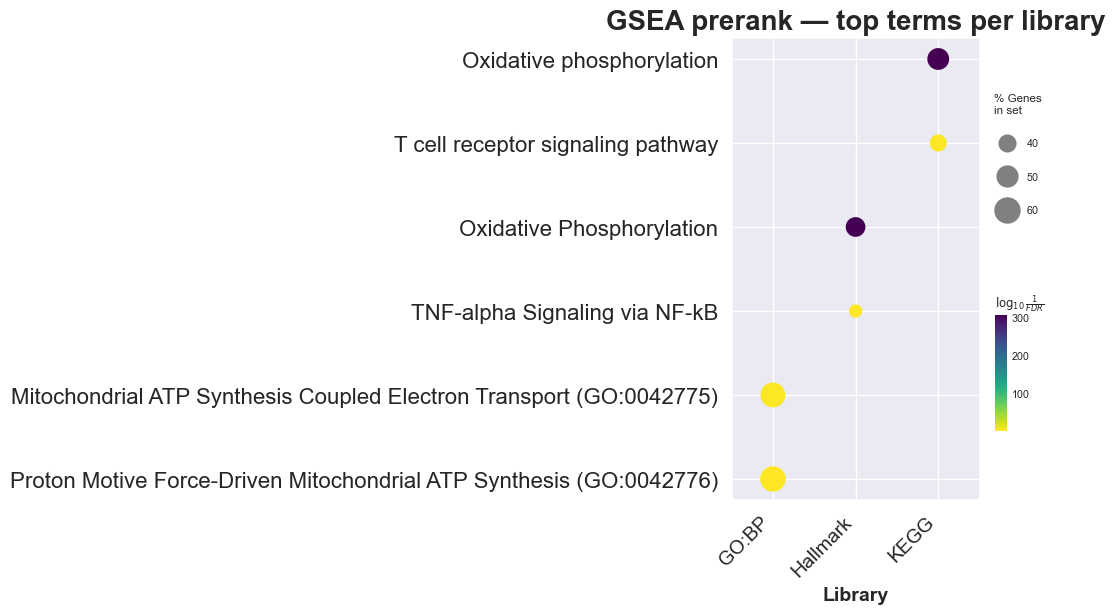

In [ ]:
def add_lib(res, lib):
    df = res.res2d.copy()
    df["Library"] = lib
    return df

plot_df = pd.concat([
    add_lib(res_h, "Hallmark"),
    add_lib(res_kegg, "KEGG"),
    add_lib(res_go, "GO:BP"),
], ignore_index=True)

plot_df = (plot_df.sort_values("FDR q-val")
           .groupby("Library", group_keys=False)
           .head(10))

gp.dotplot(plot_df,
        x="Library",
        column="FDR q-val",
        cutoff=0.25,
        top_term=2,
        title="GSEA prerank — top terms per library",
        xticklabels_rot=45)
plt.show()

In [ ]:
def top_terms(res, n=15):
    df = res.res2d.copy()
    return df.sort_values("FDR q-val").head(n)[["Term","ES","NES","NOM p-val","FDR q-val","Lead_genes"]]

top_h = top_terms(res_h, 15)
top_k = top_terms(res_kegg, 15)
top_go = top_terms(res_go, 15)

top_h

,Term,ES,NES,NOM p-val,FDR q-val,Lead_genes
0,Interferon Alpha Response,-0.538865,-2.135855,0.0,0.0,GBP2;STAT2;IRF9;PARP9;CASP8;EIF2AK2;IFI44;DHX5...
7,Oxidative Phosphorylation,0.294913,1.431947,0.00365,0.075946,PDHB;CS;HADHB;ABCB7;IMMT;UQCRC2;ACAT1;SLC25A3;...
4,UV Response Up,-0.340947,-1.464093,0.011913,0.097021,DLG4;FKBP4;ENO2;TGFBRAP1;DNAJB1;C4BPB;PRKACA;M...
2,Mitotic Spindle,-0.340778,-1.501135,0.004868,0.110471,VCL;PLEKHG2;FGD6;KIF1B;ARAP3;FSCN1;KATNA1;NEDD...
6,Unfolded Protein Response,0.320032,1.432154,0.011236,0.11367,FUS;DDX10;CNOT4;IGFBP1;ATP6V0D1;KDELR3;NOP14;W...
3,p53 Pathway,-0.334053,-1.467139,0.004645,0.115393,LIF;ACVR1B;RAP2B;IRAK1;ZFP36L1;EI24;CSRNP2;NDR...
1,Interferon Gamma Response,-0.343992,-1.514534,0.001393,0.143428,STAT2;ITGB7;IRF9;STAT1;CASP7;CASP8;EIF2AK2;IFI...
8,TNF-alpha Signaling via NF-kB,-0.31783,-1.39935,0.018544,0.149936,LIF;DNAJB4;PHLDA1;TUBB2A;FJX1;BCL6;TRIB1;IL7R;...
5,Myc Targets V1,0.293622,1.432464,0.003876,0.226344,LSM7;CUL1;RPS6;SLC25A3;EIF3D;ABCE1;UBE2E1;GSPT...
10,Spermatogenesis,-0.313288,-1.307199,0.052782,0.263077,MEP1B;MLF1;TEKT2;ACE;GAD1;ACRBP;HSPA1L;MLLT10;...


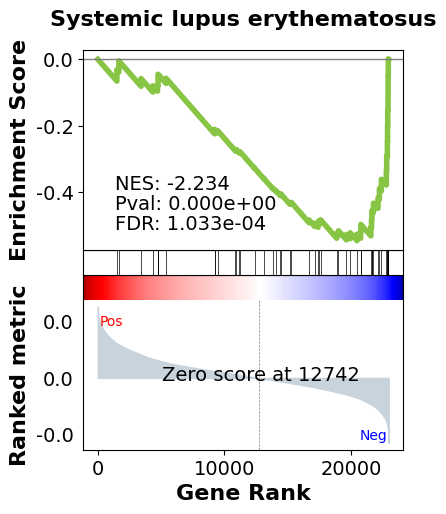

In [ ]:
terms = res_kegg.res2d.Term
axs = res_kegg.plot(terms=terms[14])

In [ ]:
reactome_lib = "Reactome_2022"
kegg_lib = "KEGG_2021_Human"

reactome_sets = gp.get_library(name=reactome_lib, organism="Human")
kegg_sets = gp.get_library(name=kegg_lib, organism="Human")

keywords = [
    "drug", "adme", "xenobi", "cytochrome", "cyp", "phase i", "phase ii",
    "glucuron", "sulfat", "ugt", "sult", "n-acetyl", "nat", "gst",
    "abc transporter", "abcb", "abcc", "slc", "p450"
]

def filter_sets(gs_dict, keywords):
    kw = tuple(k.lower() for k in keywords)
    return {term: genes for term, genes in gs_dict.items()
            if any(k in term.lower() for k in kw)}

reactome_drug = filter_sets(reactome_sets, keywords)
kegg_drug = filter_sets(kegg_sets, keywords)

print("Reactome drug-related sets:", len(reactome_drug))
print("KEGG drug-related sets:", len(kegg_drug))

res_reactome = gp.prerank(
    rnk=rnk,
    gene_sets=reactome_drug,
    permutation_num=2000,
    # min_size=10,
    # max_size=500,
    seed=42,
    outdir="gsea_reactome_drug",
    verbose=True,
)

res_kegg = gp.prerank(
    rnk=rnk,
    gene_sets=kegg_drug,
    permutation_num=2000,
    # min_size=10,
    # max_size=500,
    seed=42,
    outdir="gsea_kegg_drug",
    verbose=True,
)

2025-12-18 00:20:51,873 [INFO] Input gene rankings contains duplicated IDs
2025-12-18 00:20:51,885 [INFO] Parsing data files for GSEA.............................
2025-12-18 00:20:51,923 [INFO] 0018 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-18 00:20:51,926 [INFO] 0049 gene_sets used for further statistical testing.....
2025-12-18 00:20:51,927 [INFO] Start to run GSEA...Might take a while..................


Reactome drug-related sets: 67
KEGG drug-related sets: 10


2025-12-18 00:21:00,647 [INFO] Congratulations. GSEApy runs successfully................

2025-12-18 00:21:00,667 [INFO] Input gene rankings contains duplicated IDs
2025-12-18 00:21:00,673 [INFO] Parsing data files for GSEA.............................
2025-12-18 00:21:00,695 [INFO] 0001 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-18 00:21:00,696 [INFO] 0009 gene_sets used for further statistical testing.....
2025-12-18 00:21:00,696 [INFO] Start to run GSEA...Might take a while..................
2025-12-18 00:21:04,510 [INFO] Congratulations. GSEApy runs successfully................



In [151]:
res_reactome.res2d.sort_values("FDR q-val", ascending=True).head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,EGR2 And SOX10-mediated Initiation Of Schwann ...,-0.532562,-1.665345,0.00786,0.180968,0.188,12/27,18.68%,WWTR1;LAMC1;NAB2;LAMA2;DAG1;HMGCR;NAB1;MPZ;PXM...
7,prerank,Translocation Of SLC2A4 (GLUT4) To Plasma Memb...,0.357737,1.388863,0.048748,0.227168,0.6385,14/49,11.61%,EXOC4;STXBP3;RALGAPA2;REXO2;EXOC2;YWHAE;EXOC6;...
9,prerank,Nicotinate Metabolism R-HSA-196807,0.398204,1.352125,0.093909,0.245236,0.711,8/29,8.69%,PARP8;NNMT;NUDT12;NMNAT3;PTGS2;QPRT;PARP4;NAMPT
10,prerank,RNA Polymerase III Transcription Termination R...,0.424918,1.324649,0.116447,0.257276,0.7665,10/20,33.40%,POLR3C;POLR3F;POLR3H;NFIA;POLR3B;POLR3K;POLR3A...
6,prerank,Vitamin B5 (Pantothenate) Metabolism R-HSA-199220,0.473421,1.388895,0.100114,0.264918,0.6385,6/16,16.39%,PANK3;VNN2;PANK4;VNN1;PPCS;ENPP1
5,prerank,FGFR2 Alternative Splicing R-HSA-6803529,0.421434,1.396921,0.068238,0.300859,0.6185,9/25,21.19%,ESRP1;HNRNPH1;HNRNPA1;RBFOX2;TIAL1;PTBP1;NCBP2...
12,prerank,Mitochondrial Translation Termination R-HSA-54...,0.298759,1.273736,0.082517,0.307233,0.863,30/79,25.99%,MRPS14;MRPS33;MRRF;MRPS9;MRPL33;MRPS27;MRPL30;...
4,prerank,Phase II - Conjugation Of Compounds R-HSA-156580,0.318,1.403073,0.027735,0.361648,0.603,22/94,15.21%,SLC38A1;GSTM2;NNMT;BPNT1;GCLC;SLC38A3;MGST2;ES...
3,prerank,RNA Polymerase II Transcription Termination R-...,0.353487,1.434707,0.033094,0.399445,0.543,30/59,26.74%,PAPOLA;CPSF3;SYMPK;SRSF4;THOC1;CPSF7;DDX39A;SR...
2,prerank,"Gamma Carboxylation, Hypusine Formation And Ar...",0.400546,1.475918,0.029851,0.459944,0.4615,24/40,33.65%,ARSI;ARSB;ARSD;STS;DPH5;F8;ARSH;FN3KRP;DHPS;F7...


## PCA on trimmed

In [319]:
with open("interesting_genes.txt", "r") as f:
    interesting_genes = [int(line.strip()) for line in f.readlines()]
mini_pca = rna_seq_grouped_T.loc[:, interesting_genes].join(rna_seq_grouped_T.loc[:, ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]])

In [320]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

meta_cols = ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]
X = mini_pca.drop(columns=meta_cols, errors="ignore")

X.columns = X.columns.astype(str)
X = X.astype(float)
df_train, df_test = train_test_split(X, test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)


scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)
val_scaled = scaler.transform(df_val)

pca = PCA(n_components=len(train_scaled))
pcs_array = pca.fit_transform(train_scaled)
pc_train = pd.DataFrame(
    pcs_array,
    index=df_train.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_test = pd.DataFrame(
    pca.transform(test_scaled),
    index=df_test.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_val = pd.DataFrame(
    pca.transform(val_scaled),
    index=df_val.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_train[meta_cols] = mini_pca.loc[pc_train.index, meta_cols]
pc_test[meta_cols] = mini_pca.loc[pc_test.index, meta_cols]
pc_val[meta_cols] = mini_pca.loc[pc_val.index, meta_cols]

print(f"Selected {pca.n_components_} PCs explaining {pca.explained_variance_ratio_.sum():.4f} of variance")
pc_train.head()

Selected 110 PCs explaining 1.0000 of variance


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PATIENT_ID,OS_DAYS,OS_STATUS
145,-41.002533,-11.430694,13.386168,-5.208423,-7.077387,2.857944,14.230245,12.063947,3.169379,2.223364,...,-3.595827,-3.660000,1.344191,0.546428,-0.228915,-0.239263,1.743591e-14,TARGET-10-PASHUI,605.0,1.0
132,-69.057111,15.704608,-33.102197,15.139280,7.414948,14.759346,-12.238316,20.624776,-1.853543,-3.068939,...,-0.056904,0.308605,-0.727636,-0.053756,-0.011783,-0.302768,1.743591e-14,TARGET-10-PARSGC,2829.0,0.0
87,-14.049735,-24.371754,-3.927997,-17.627303,7.983081,-9.742530,-6.599335,8.513831,1.535167,2.367614,...,0.493095,-0.964843,0.757448,-0.618936,0.281403,0.530014,1.743591e-14,TARGET-10-PAPKNC,1413.0,1.0
146,89.377241,61.425793,-1.820346,-32.856730,-10.816761,29.982091,10.420959,-3.974185,-6.983563,-5.754397,...,0.132769,0.583979,-0.375041,0.028907,0.097099,0.224477,1.743591e-14,TARGET-10-PASKAY,487.0,1.0
106,11.249667,-13.318380,-30.415814,7.971125,4.850538,-20.862939,-18.299357,35.508130,-28.969837,22.183708,...,-0.085079,-2.077907,1.009725,0.160810,-1.375249,-1.067235,1.743591e-14,TARGET-10-PAPZST,859.0,0.0


In [321]:
pc_cols = [c for c in pc_train.columns if c.startswith("PC")]

max_k = 110

def objective(trial):
    k = trial.suggest_int("n_components", 2, max_k)
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    use_cols = pc_cols[:k] + ["OS_DAYS", "OS_STATUS"]
    tr = pc_train[use_cols].copy()
    te = pc_val[use_cols].copy()

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph.fit(tr, duration_col="OS_DAYS", event_col="OS_STATUS", show_progress=False)

    score = cph.score(te, scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 21:42:05,121] A new study created in memory with name: no-name-16f66ae8-f9a3-47fb-8b5e-9e7c0d7f7e92
[I 2025-12-18 21:42:05,551] Trial 4 finished with value: 0.8611111111111112 and parameters: {'n_components': 7, 'penalizer': 0.12823169203341117, 'l1_ratio': 0.47436323350861864}. Best is trial 4 with value: 0.8611111111111112.
[I 2025-12-18 21:42:06,818] Trial 3 finished with value: 0.8263888888888888 and parameters: {'n_components': 50, 'penalizer': 0.0024286532232670292, 'l1_ratio': 0.9749406904944502}. Best is trial 4 with value: 0.8611111111111112.
[I 2025-12-18 21:42:07,240] Trial 2 finished with value: 0.7916666666666666 and parameters: {'n_components': 52, 'penalizer': 1.139855758673804, 'l1_ratio': 0.0027439724020498213}. Best is trial 4 with value: 0.8611111111111112.
[I 2025-12-18 21:42:07,385] Trial 10 finished with value: 0.8125 and parameters: {'n_components': 17, 'penalizer': 0.0242912400999103, 'l1_ratio': 0.17252261590446716}. Best is trial 4 with value: 0.

Best params: {'n_components': 9, 'penalizer': 0.0012987585712594793, 'l1_ratio': 0.4580986584409129}
Best c-index: 0.8819444444444444


In [322]:
selected_k = 9
selected_train = pc_train.loc[:, :f'PC{selected_k}'].join(pc_train.loc[:, ["OS_DAYS", "OS_STATUS"]])
selected_test = pc_test.loc[:, :f'PC{selected_k}'].join(pc_test.loc[:, ["OS_DAYS", "OS_STATUS"]])
cph = CoxPHFitter(penalizer=0.0012987585712594793, l1_ratio=0.4580986584409129)
cph.fit(selected_train, duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 110 total observations, 46 right-censored observations>

In [323]:
print(cph.score(selected_train, scoring_method="concordance_index"))
print(cph.score(selected_test, scoring_method="concordance_index"))

0.7970487596236099
0.6047619047619047


In [324]:
cph.summary[cph.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PC1,0.029244,1.029676,0.007778,0.014000,0.044489,1.014099,1.045493,0.0,3.760012,1.699052e-04,12.522983
PC4,-0.039267,0.961494,0.007887,-0.054726,-0.023809,0.946745,0.976472,0.0,-4.978740,6.399948e-07,20.575436
PC5,0.035798,1.036446,0.011490,0.013278,0.058317,1.013367,1.060051,0.0,3.115611,1.835639e-03,9.089502


In [325]:
filtered_pcas = cph.summary[cph.summary.p < 0.05]
filtered_pcas = filtered_pcas.reset_index(names="pca").pca.str[2:].astype(int)

cox_coef = cph.params_.values[filtered_pcas - 1]
pca_loadings = pca.components_[filtered_pcas - 1].T

original_importance = pca_loadings @ cox_coef

importance_df = pd.DataFrame(
    {
        "feature": df_train.columns,
        "importance": original_importance
    }
).sort_values("importance", key=np.abs, ascending=False)

child = importance_df

In [326]:
id2hugo = (
    rna_seq.loc[:, ["Entrez_Gene_Id", "Hugo_Symbol"]]
    .drop_duplicates(subset="Entrez_Gene_Id")
    .set_index("Entrez_Gene_Id")["Hugo_Symbol"]
    .to_dict()
)
id2hugo = {str(k): v for k, v in id2hugo.items()}

importance_df["Hugo_Symbol"] = importance_df["feature"].astype(str).map(id2hugo).fillna(importance_df["feature"].astype(str))

importance_df = importance_df[["Hugo_Symbol", "feature", "importance"]]
importance_df.to_csv("importance_genes_hugo.csv", index=False)

importance_df.head(30)

,Hugo_Symbol,feature,importance
1116,NOTCH2,4853,0.002249
1711,GPR137B,7107,0.002224
1370,PTPRJ,5795,0.002163
585,FGR,2268,0.002162
3971,ZNF287,57336,0.002152
1799,XBP1,7494,-0.002119
2385,SIRPB1,10326,0.002118
2125,CD101,9398,0.002114
3031,FBXO10,26267,0.002108
1490,S100A11,6282,0.002101


In [ ]:
rnk = importance_df.drop("feature", axis=1).rename({"Hugo_Symbol":"feature"}, axis=1)

res_h = gp.prerank(
    rnk=rnk,
    gene_sets="MSigDB_Hallmark_2020",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_hallmark",
    verbose=True,
)

res_kegg = gp.prerank(
    rnk=rnk,
    gene_sets="KEGG_2021_Human",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_kegg",
)

res_go = gp.prerank(
    rnk=rnk,
    gene_sets="GO_Biological_Process_2023",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_go_bp",
)

2025-12-18 04:09:49,962 [INFO] Input gene rankings contains duplicated IDs
2025-12-18 04:09:49,978 [INFO] Parsing data files for GSEA.............................
2025-12-18 04:09:49,988 [INFO] Enrichr library gene sets already downloaded in: /Users/viktornekrasov/.cache/gseapy, use local file
2025-12-18 04:09:50,003 [INFO] 0002 gene_sets have been filtered out when max_size=500 and min_size=10
2025-12-18 04:09:50,004 [INFO] 0048 gene_sets used for further statistical testing.....
2025-12-18 04:09:50,004 [INFO] Start to run GSEA...Might take a while..................
2025-12-18 04:10:06,979 [INFO] Congratulations. GSEApy runs successfully................



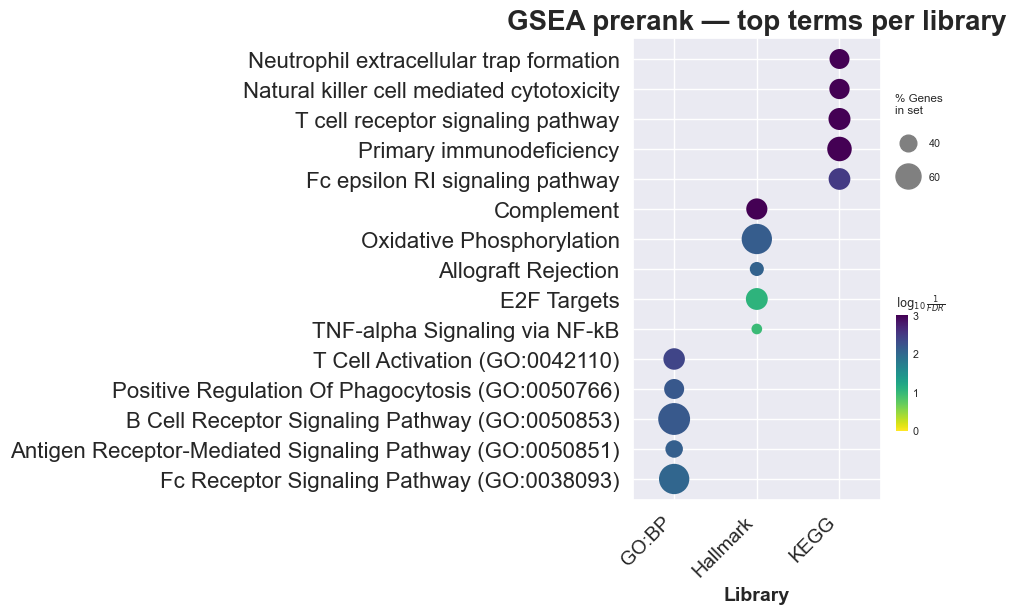

In [ ]:
def add_lib(res, lib):
    df = res.res2d.copy()
    df["Library"] = lib
    return df

plot_df = pd.concat([
    add_lib(res_h, "Hallmark"),
    add_lib(res_kegg, "KEGG"),
    add_lib(res_go, "GO:BP"),
], ignore_index=True)

plot_df = (plot_df.sort_values("FDR q-val")
           .groupby("Library", group_keys=False)
           .head(10))

gp.dotplot(plot_df,
        x="Library",
        column="FDR q-val",
        cutoff=0.25,
        top_term=5,
        title="GSEA prerank — top terms per library",
        xticklabels_rot=45)
plt.show()

In [161]:
res_h.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Androgen Response,0.522888,1.812783,0.001994,0.025725,0.0195,18/42,18.52%,ELOVL5;B4GALT1;TMEM50A;INSIG1;MERTK;ITGAV;UBE2...
1,prerank,G2-M Checkpoint,0.416393,1.710144,0.0,0.040237,0.0585,32/107,21.01%,HIRA;UPF1;NUP50;NOTCH2;DR1;CHMP1A;CTCF;ATF5;OD...
2,prerank,UV Response Dn,0.435971,1.59212,0.011089,0.095425,0.1935,22/52,22.88%,NOTCH2;APBB2;MAP1B;INSIG1;PIK3R3;SLC7A1;KCNMA1...
3,prerank,Interferon Gamma Response,-0.409114,-1.581378,0.00497,0.150947,0.1915,29/66,23.69%,HLA-A;PDE4B;SLC25A28;BANK1;HLA-DRB1;PML;XAF1;M...
4,prerank,Epithelial Mesenchymal Transition,0.402243,1.557657,0.00498,0.094325,0.248,30/69,23.67%,NID2;CALD1;NOTCH2;SDC1;ITGAV;COL1A1;LRRC15;GEM...
5,prerank,mTORC1 Signaling,0.371805,1.500879,0.005786,0.12348,0.375,36/95,22.53%,HSPA9;ELOVL5;YKT6;PSAT1;ASNS;INSIG1;PIK3R3;SLC...
6,prerank,Mitotic Spindle,0.381192,1.465171,0.019487,0.135551,0.4625,25/67,23.10%,BCL2L11;SORBS2;NOTCH2;EPB41L2;BCR;KIF3B;MARK4;...
7,prerank,Complement,0.378218,1.463435,0.020772,0.117789,0.466,31/67,24.63%,RNF4;DOCK10;FDX1;PPP4C;PHEX;COL4A2;SERPINA1;CD...
8,prerank,Myogenesis,0.373272,1.428415,0.021847,0.134727,0.554,21/64,16.05%,MYO1C;DMPK;MRAS;AEBP1;SORBS1;AKT2;PSEN2;STC2;C...
9,prerank,Interferon Alpha Response,-0.475421,-1.402662,0.076313,0.325142,0.599,9/20,17.69%,HLA-C;SLC25A28;MX1;RNF31;HERC6;STAT2;IRF9;LPAR...


In [ ]:
reactome_sets = gp.get_library(name="Reactome_2022", organism="Human")
kegg_sets     = gp.get_library(name="KEGG_2021_Human", organism="Human")

keep_reactome_terms = [
    "Drug ADME",
    "Phase I - Functionalization of compounds",
    "Phase II - Conjugation of compounds",
    "Phase III - Transport of compounds",
]
keep_kegg_terms = [
    "Drug metabolism",
    "Metabolism of xenobiotics by cytochrome P450",
    "Xenobiotics biodegradation and metabolism"
]

In [163]:
def keep_only(gs_dict, keep_list):
    keep_list_l = [k.lower() for k in keep_list]
    out = {}
    for term, genes in gs_dict.items():
        t = term.lower()
        if any(k in t for k in keep_list_l):
            out[term] = genes
    return out

reactome_drug = keep_only(reactome_sets, keep_reactome_terms)
kegg_drug     = keep_only(kegg_sets, keep_kegg_terms)

In [164]:
reactome_drug.keys()

dict_keys(['Drug ADME R-HSA-9748784', 'Phase I - Functionalization Of Compounds R-HSA-211945', 'Phase II - Conjugation Of Compounds R-HSA-156580'])

In [165]:
matches = [k for k in reactome_sets.keys() if "compounds" in k.lower()]
print(f"Found {len(matches)} KEGG terms containing 'drug':")
for t in matches:
    print("-", t)
matches

Found 3 KEGG terms containing 'drug':
- Phase I - Functionalization Of Compounds R-HSA-211945
- Phase II - Conjugation Of Compounds R-HSA-156580
- Transport Of Bile Salts And Organic Acids, Metal Ions And Amine Compounds R-HSA-425366


['Phase I - Functionalization Of Compounds R-HSA-211945',
 'Phase II - Conjugation Of Compounds R-HSA-156580',
 'Transport Of Bile Salts And Organic Acids, Metal Ions And Amine Compounds R-HSA-425366']

In [166]:
kegg_drug.keys()

dict_keys(['Drug metabolism', 'Metabolism of xenobiotics by cytochrome P450'])

In [167]:
res_reactome_drug = gp.prerank(
    rnk=rnk,
    gene_sets=reactome_drug,
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_kegg",
)

res_kegg_drug = gp.prerank(
    rnk=rnk,
    gene_sets=kegg_drug,
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_kegg",
)

In [168]:
res_reactome_drug.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Phase II - Conjugation Of Compounds R-HSA-156580,-0.303657,-1.006447,0.44354,0.881605,0.59246,6/31,10.78%,CNDP2;SLC26A1;GSTP1;MGST2;GGCT;AKR1A1
1,prerank,Phase I - Functionalization Of Compounds R-HSA...,0.308446,0.986974,0.477867,0.47309,0.5265,5/29,17.11%,FDX1;CYP1A1;AOC2;CYP1B1;CYP27B1
2,prerank,Drug ADME R-HSA-9748784,-0.221085,-0.700349,0.908092,0.923746,0.964093,4/28,18.01%,CNDP2;GSTP1;ACY1;IMPDH2


In [169]:
res_kegg_drug.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Drug metabolism,-0.3797,-1.340468,0.069307,0.176644,0.11747,18/42,29.84%,TK2;GSTP1;ALDH3B2;MGST2;CMPK1;DUT;TK1;FMO5;NME...
1,prerank,Metabolism of xenobiotics by cytochrome P450,-0.388209,-1.16819,0.233463,0.221295,0.273343,7/22,20.43%,GSTP1;ALDH3B2;MGST2;AKR7A2;ADH5;HSD11B1;GSTO2


## RNA + clinical

In [242]:
with open("interesting_genes.txt", "r") as f:
    interesting_genes = [int(line.strip()) for line in f.readlines()]
mini_pca = rna_seq_grouped_T.loc[:, interesting_genes].join(rna_seq_grouped_T.loc[:, ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

meta_cols = ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]
X = mini_pca.drop(columns=meta_cols, errors="ignore")

X.columns = X.columns.astype(str)
X = X.astype(float)
df_train, df_test = train_test_split(X, test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)


scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)
val_scaled = scaler.transform(df_val)

pca = PCA(n_components=len(train_scaled))
pcs_array = pca.fit_transform(train_scaled)
pc_train = pd.DataFrame(
    pcs_array,
    index=df_train.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_test = pd.DataFrame(
    pca.transform(test_scaled),
    index=df_test.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_val = pd.DataFrame(
    pca.transform(val_scaled),
    index=df_val.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_train[meta_cols] = mini_pca.loc[pc_train.index, meta_cols]
pc_test[meta_cols] = mini_pca.loc[pc_test.index, meta_cols]
pc_val[meta_cols] = mini_pca.loc[pc_val.index, meta_cols]

print(f"Selected {pca.n_components_} PCs explaining {pca.explained_variance_ratio_.sum():.4f} of variance")
pc_train.head()

Selected 110 PCs explaining 1.0000 of variance


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PATIENT_ID,OS_DAYS,OS_STATUS
64,-3.178577,-4.385081,8.493997,33.379994,-2.229852,-10.637960,11.774897,6.863104,-1.509876,7.243249,...,2.974617,-3.902181,-0.042226,0.732953,-1.490452,2.232548,1.676970e-14,TARGET-10-PAPESW,3542.0,0.0
22,-62.238942,64.254446,20.645727,8.015137,21.187118,2.763205,-15.080227,-6.748647,-5.825474,7.283228,...,-0.265657,-0.750413,0.741814,-0.062610,-0.404656,0.311798,1.676970e-14,TARGET-10-PANSHK,2447.0,1.0
87,-5.206134,-23.084554,-2.392263,-6.821156,1.429400,-3.227531,-5.927599,-9.291938,-5.712400,12.826597,...,4.970016,2.620550,-6.606080,2.482719,-2.605822,15.492240,1.676970e-14,TARGET-10-PAPLDL,1187.0,1.0
45,-26.923710,-9.341584,24.407203,16.582604,-7.344699,-11.318640,17.346419,7.129451,5.062483,-5.628162,...,-0.986526,1.813897,0.373354,0.255754,-1.031742,-0.064366,1.676970e-14,TARGET-10-PAPACP,2378.0,1.0
106,76.500387,57.382791,25.151362,-23.774011,-8.379097,-5.683222,3.137577,7.316886,1.810803,3.522551,...,0.141772,0.027735,0.304479,0.065043,-0.362581,0.047625,1.676970e-14,TARGET-10-PARACA,806.0,1.0


In [ ]:
combined_ohe['PATIENT_ID'] = combined_ohe['PATIENT_ID'].astype(str)
pc_train['PATIENT_ID'] = pc_train['PATIENT_ID'].astype(str)

merged_sample_pc_train = pd.merge(
	combined_ohe.loc[:, ["PATIENT_ID", "BONE_MARROW_SITE_OF_RELAPSE"]],
	pc_train.loc[:, ["PATIENT_ID", "PC1", "PC4", "PC5", "OS_DAYS", "OS_STATUS"]],
	on="PATIENT_ID",
	how="inner",
)
merged_sample_pc_test = pd.merge(
    combined_ohe.loc[:, ["PATIENT_ID", "BONE_MARROW_SITE_OF_RELAPSE"]],
    pc_test.loc[:, ["PATIENT_ID", "PC1", "PC4", "PC5", "OS_DAYS", "OS_STATUS"]],
    on="PATIENT_ID",
    how="inner",
)
merged_sample_pc_val = pd.merge(
    combined_ohe.loc[:, ["PATIENT_ID", "BONE_MARROW_SITE_OF_RELAPSE"]],
    pc_val.loc[:, ["PATIENT_ID", "PC1", "PC4", "PC5", "OS_DAYS", "OS_STATUS"]],
    on="PATIENT_ID",
    how="inner",
)

In [263]:
merged_sample_pc_train

,PATIENT_ID,BONE_MARROW_SITE_OF_RELAPSE,PC1,PC4,PC5,OS_DAYS,OS_STATUS
0,TARGET-10-PAMXHJ,0.0,-4.575796,36.846831,2.408416,4089.0,0.0
1,TARGET-10-PAMXSP,0.0,-19.816616,16.910714,-2.757186,4383.0,0.0
2,TARGET-10-PANCVR,1.0,-0.648327,-14.263319,7.601165,473.0,1.0
3,TARGET-10-PANDWE,1.0,-26.706414,-7.592332,14.039938,1571.0,1.0
4,TARGET-10-PANFNZ,1.0,-19.807373,3.213944,5.299250,2778.0,1.0
...,...,...,...,...,...,...,...
88,TARGET-10-PASFXA,1.0,34.480101,-24.218673,9.328550,645.0,1.0
89,TARGET-10-PASHUI,1.0,-35.478041,0.908440,-8.563247,605.0,1.0
90,TARGET-10-PASKHT,1.0,-29.338623,-10.289736,35.787893,716.0,1.0
91,TARGET-10-PASLZM,1.0,60.844633,-30.060322,-6.303997,407.0,1.0


In [264]:
cph = CoxPHFitter()
cph.fit(merged_sample_pc_train.drop("PATIENT_ID", axis=1), duration_col = "OS_DAYS", event_col = "OS_STATUS")

<lifelines.CoxPHFitter: fitted with 93 total observations, 37 right-censored observations>

In [267]:
print(cph.score(merged_sample_pc_train, scoring_method="concordance_index"))
print(cph.score(merged_sample_pc_test, scoring_method="concordance_index"))
print(cph.score(merged_sample_pc_val, scoring_method="concordance_index"))

0.8041087962962963
0.7445255474452555
0.7633587786259542


In [ ]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    train = merged_sample_pc_train.drop(columns=["PATIENT_ID"], errors="ignore")
    test = merged_sample_pc_val.drop(columns=["PATIENT_ID"], errors="ignore")

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph.fit(train, duration_col="OS_DAYS", event_col="OS_STATUS", show_progress=False)

    score = cph.score(test, scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 01:29:17,618] A new study created in memory with name: no-name-46b08d81-4b83-485d-a725-c58827df0d56
[I 2025-12-18 01:29:17,724] Trial 0 finished with value: 0.7709923664122137 and parameters: {'penalizer': 0.011137147034412464, 'l1_ratio': 0.5412148779829438}. Best is trial 0 with value: 0.7709923664122137.
[I 2025-12-18 01:29:17,833] Trial 1 finished with value: 0.7709923664122137 and parameters: {'penalizer': 0.007626028298959825, 'l1_ratio': 0.026817706034080846}. Best is trial 0 with value: 0.7709923664122137.
[I 2025-12-18 01:29:17,939] Trial 8 finished with value: 0.7633587786259542 and parameters: {'penalizer': 0.032874122330408, 'l1_ratio': 0.24423255760595508}. Best is trial 0 with value: 0.7709923664122137.
[I 2025-12-18 01:29:17,940] Trial 7 finished with value: 0.7633587786259542 and parameters: {'penalizer': 0.0017312589492605702, 'l1_ratio': 0.20835071136539618}. Best is trial 0 with value: 0.7709923664122137.
[I 2025-12-18 01:29:17,963] Trial 2 finished wit

Best params: {'penalizer': 0.018370974697438442, 'l1_ratio': 0.6698281831594454}
Best c-index: 0.7786259541984732


In [274]:
cph = CoxPHFitter(penalizer=study.best_params["penalizer"], l1_ratio=study.best_params["l1_ratio"])
cph.fit(merged_sample_pc_train.drop(columns=["PATIENT_ID"]), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 93 total observations, 37 right-censored observations>

In [276]:
print(cph.score(merged_sample_pc_train, scoring_method="concordance_index"))
print(cph.score(merged_sample_pc_val, scoring_method="concordance_index"))
print(cph.score(merged_sample_pc_test, scoring_method="concordance_index"))

0.8064236111111112
0.7786259541984732
0.7518248175182481


In [277]:
cph.summary[cph.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
BONE_MARROW_SITE_OF_RELAPSE,1.642476,5.167952,0.580785,0.504158,2.780795,1.655591,16.131841,0.0,2.828026,4.683595e-03,7.738168
PC1,0.018981,1.019163,0.005938,0.007344,0.030619,1.007371,1.031092,0.0,3.196841,1.389416e-03,9.491306
PC4,-0.038926,0.961822,0.006770,-0.052196,-0.025657,0.949143,0.974669,0.0,-5.749635,8.943635e-09,26.736491
PC5,0.027581,1.027965,0.010747,0.006518,0.048645,1.006539,1.049848,0.0,2.566440,1.027484e-02,6.604740


## Common genes

In [327]:
interesting_stepa = pd.read_csv("/Users/viktornekrasov/Downloads/small_gene_set_adults.csv").feature.tolist()
interesting_adult = set()
for i in interesting_stepa:
    interesting_adult.add(i.rsplit(".")[0])
with open("interesting_genes.txt", "r") as f:
    interesting_genes = [int(line.strip()) for line in f.readlines()]

id2hugo_raw = (
    rna_seq.loc[:, ["Entrez_Gene_Id", "Hugo_Symbol"]]
    .drop_duplicates(subset="Entrez_Gene_Id")
    .set_index("Entrez_Gene_Id")["Hugo_Symbol"]
    .to_dict()
)

id2hugo = {}
for k, v in id2hugo_raw.items():
    try:
        id2hugo[int(k)] = v
    except Exception:
        id2hugo[str(k)] = v
    id2hugo[str(k)] = v

interesting_genes_hugo = [id2hugo.get(g, id2hugo.get(str(g), str(g))) for g in interesting_genes]

ig_df = pd.DataFrame({"Entrez_Gene_Id": interesting_genes, "Hugo_Symbol": interesting_genes_hugo})
common = interesting_adult.intersection(set(ig_df.Hugo_Symbol.tolist()))

inv_map = {v: k for k, v in id2hugo.items()}

mapped = [
    int(inv_map.get(g, inv_map.get(str(g), g)))
    for g in common
]

micro_pca = rna_seq_grouped_T.loc[:, mapped].join(rna_seq_grouped_T.loc[:, ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]])

In [328]:
adult = pd.read_csv("/Users/viktornekrasov/Downloads/small_gene_set_adults.csv")
adult

,Unnamed: 0,feature,importance
0,2388,CEACAM22P,5.183445e-02
1,245,CEACAM16,5.147347e-02
2,209,CTB-171A8.1,5.098474e-02
3,360,IGSF23,5.075759e-02
4,357,TBC1D3P5,4.799875e-02
...,...,...,...
13414,5014,CBFA2T3,-1.981971e-06
13415,9147,RABL2B,-1.758273e-06
13416,6553,AC098789.1,-1.265616e-06
13417,7360,CTBP1,9.948364e-07


In [329]:
child['feature'] = child['feature'].map(id2hugo).fillna(child['feature'].astype(str))
child

,feature,importance,Hugo_Symbol
1116,NOTCH2,2.249443e-03,NOTCH2
1711,GPR137B,2.223609e-03,GPR137B
1370,PTPRJ,2.163164e-03,PTPRJ
585,FGR,2.161959e-03,FGR
3971,ZNF287,2.152018e-03,ZNF287
...,...,...,...
2835,DICER1,-5.174855e-07,DICER1
3597,PALMD,-3.831377e-07,PALMD
5610,C2orf69,3.183315e-07,C2orf69
4970,PGLYRP3,-2.953285e-07,PGLYRP3


In [330]:
tmp_child = child[child['feature'].isin(common)][['feature', 'importance']].copy()
tmp_adult  = adult[adult['feature'].isin(common)][['feature', 'importance']].copy()

tmp_child = tmp_child.groupby('feature', as_index=False).mean()
tmp_adult  = tmp_adult.groupby('feature', as_index=False).mean()

importances = pd.concat([tmp_child, tmp_adult], ignore_index=True)
importances = importances.groupby('feature', as_index=False).mean()

importances = importances.sort_values('importance', key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

importances.head()

,feature,importance
0,CEACAM16,0.025859
1,ANKRD13B,0.014998
2,VDR,0.013497
3,GRIK4,0.012869
4,OR2T3,0.012131


In [186]:
importances

,feature,importance
0,CEACAM16,0.025860
1,ANKRD13B,0.014997
2,VDR,0.013500
3,GRIK4,0.012871
4,OR2T3,0.012129
...,...,...
2722,WDR12,0.000003
2723,SS18L2,0.000003
2724,NCAPD3,0.000003
2725,ZFYVE19,-0.000002


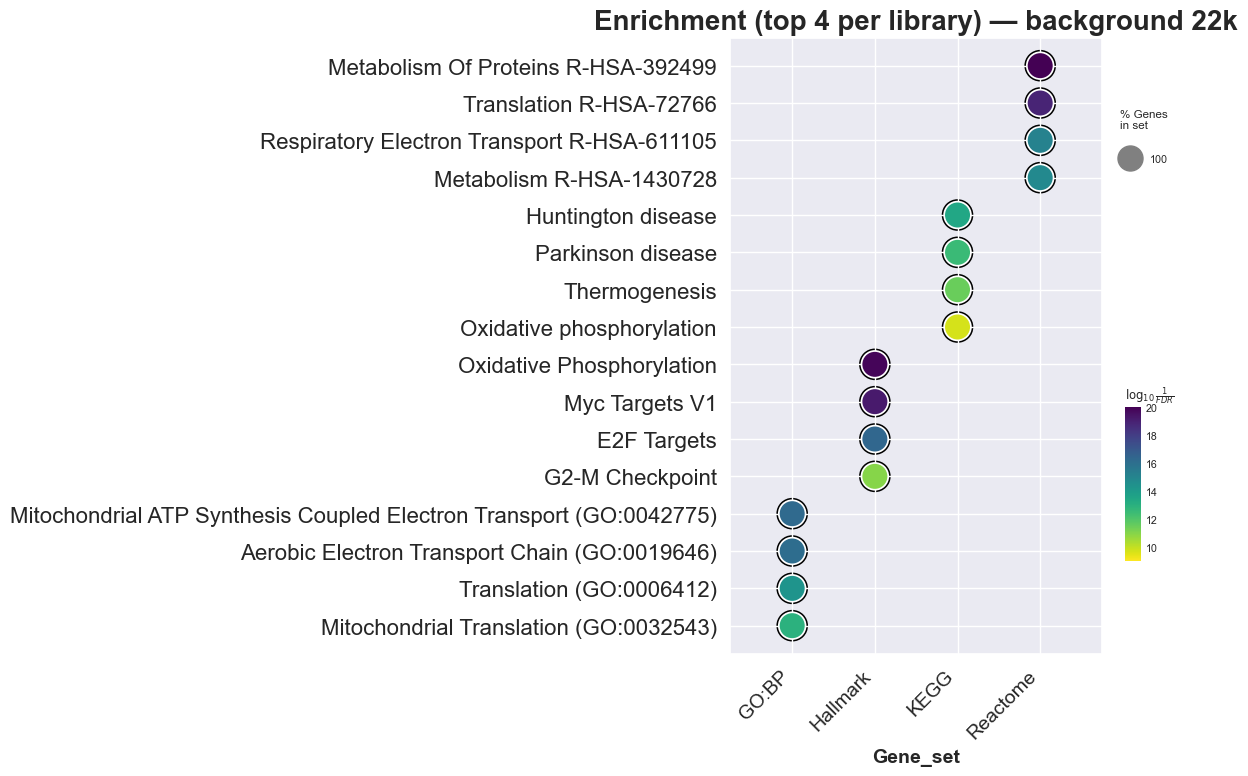

In [ ]:
import pandas as pd
import gseapy as gp
from gseapy import dotplot

gene_list = [str(v) for v in interesting_genes_hugo]
backgrounds = {"22k":[str(v) for v in list(set(id2hugo.values()))]}

for name, background in backgrounds.items():
    enr_h = gp.enrichr(
        gene_list=gene_list, gene_sets="MSigDB_Hallmark_2020", organism="Human",
        outdir=f"enrichr_hallmark_topN_{name}", cutoff=0.25, background=background
    )
    enr_kegg = gp.enrichr(
        gene_list=gene_list, gene_sets="KEGG_2021_Human", organism="Human",
        outdir=f"enrichr_kegg_topN_{name}", cutoff=0.25, background=background
    )
    enr_reactome = gp.enrichr(
        gene_list=gene_list, gene_sets="Reactome_2022", organism="Human",
        outdir=f"enrichr_reactome_topN_{name}", cutoff=0.25, background=background
    )
    enr_go = gp.enrichr(
        gene_list=gene_list, gene_sets="GO_Biological_Process_2023", organism="Human",
        outdir=f"enrichr_go_bp_topN_{name}", cutoff=0.25, background=background
    )

    def prep(res, lib_name):
        df = res.results.copy()
        df["Gene_set"] = lib_name
        return df

    plot_df = pd.concat([
        prep(enr_h, "Hallmark"),
        prep(enr_kegg, "KEGG"),
        prep(enr_reactome, "Reactome"),
        prep(enr_go, "GO:BP"),
    ], ignore_index=True)

    TOP_PER_LIB = 4
    plot_df = (plot_df
               .sort_values("Adjusted P-value", ascending=True)
               .groupby("Gene_set", group_keys=False)
               .head(TOP_PER_LIB))

    ax = dotplot(
        plot_df,
        column="Adjusted P-value",
        x="Gene_set",
        size=3,
        top_term=TOP_PER_LIB,
        figsize=(6, 8),
        title=f"Enrichment (top {TOP_PER_LIB} per library) — background {name}",
        xticklabels_rot=45,
        show_ring=True,
        marker="o",
    )

In [15]:
unity = interesting_adult | set(ig_df.Hugo_Symbol.tolist())

In [16]:
micro_pca

,6566,8794,5888,1175,100128420,79621,100286979,5433,168537,84844,...,7247,11187,51655,100862692,123355,975,60312,PATIENT_ID,OS_DAYS,OS_STATUS
0,16.8596,0.0507,2.0112,45.5563,0.0144,39.1969,0.0819,11.8502,1.0771,14.6486,...,29.1721,0.0029,69.3521,3.2045,2.9715,27.3338,0.0231,TARGET-10-PAKSWW,1592.0,1.0
1,4.7825,0.0145,2.2064,34.4818,0.0199,52.2123,0.0238,6.4511,0.1519,2.8525,...,14.4710,0.1663,53.4060,0.8017,2.8747,39.8638,0.1628,TARGET-10-PAMXHJ,4089.0,0.0
2,4.2553,0.0741,0.7997,41.9615,0.0000,33.6573,0.0059,4.3798,0.5031,3.4408,...,10.9547,0.0033,35.4472,2.1980,1.7514,28.8890,0.0022,TARGET-10-PAMXSP,4383.0,0.0
3,9.2052,0.0152,1.8511,43.3504,0.0000,27.3207,0.0000,13.4697,0.4963,10.7957,...,8.0657,0.0097,14.8586,1.3235,1.7938,66.8819,0.0118,TARGET-10-PANCVR,473.0,1.0
4,2.2355,0.2583,0.3573,15.8923,0.1317,18.9285,0.0497,6.8777,21.0378,6.5901,...,10.1122,0.0143,65.9894,4.0159,1.1623,22.5797,0.4630,TARGET-10-PANDWE,1571.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.6481,0.2825,1.7084,176.3065,0.6010,14.6878,0.0000,15.3602,2.1234,14.3218,...,10.4654,0.1170,27.2109,0.6399,2.0570,78.0568,0.1268,TARGET-10-PASSXJ,552.0,1.0
150,4.9559,0.0000,3.7577,123.4086,0.0042,31.2854,0.0158,26.9572,0.2041,11.7357,...,10.1169,0.5097,13.8899,1.5161,1.4546,131.8677,0.2137,TARGET-10-PASUBW,474.0,1.0
151,2.6338,0.2027,2.5147,41.1511,0.1893,19.0103,0.1912,14.1430,12.8798,5.7467,...,18.4876,0.0827,2.4642,5.4819,14.2246,43.0878,0.7284,TARGET-10-PASYGM,429.0,1.0
152,1.2011,0.2484,5.6051,173.5698,0.0000,45.9494,0.0208,19.5444,0.2148,8.8898,...,21.7791,0.0000,9.0805,0.0000,3.2410,43.8029,0.5310,TARGET-10-PATCTI,482.0,1.0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

meta_cols = ["PATIENT_ID", "OS_DAYS", "OS_STATUS"]
X = micro_pca.drop(columns=meta_cols, errors="ignore")

X.columns = X.columns.astype(str)
X = X.astype(float)
df_train, df_test = train_test_split(X, test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)


scaler = StandardScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)
val_scaled = scaler.transform(df_val)

pca = PCA(n_components=len(train_scaled))
pcs_array = pca.fit_transform(train_scaled)
pc_train = pd.DataFrame(
    pcs_array,
    index=df_train.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_test = pd.DataFrame(
    pca.transform(test_scaled),
    index=df_test.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_val = pd.DataFrame(
    pca.transform(val_scaled),
    index=df_val.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pc_train[meta_cols] = micro_pca.loc[pc_train.index, meta_cols]
pc_test[meta_cols] = micro_pca.loc[pc_test.index, meta_cols]
pc_val[meta_cols] = micro_pca.loc[pc_val.index, meta_cols]

print(f"Selected {pca.n_components_} PCs explaining {pca.explained_variance_ratio_.sum():.4f} of variance")
pc_train.head()

Selected 110 PCs explaining 1.0000 of variance


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PATIENT_ID,OS_DAYS,OS_STATUS
145,-27.282719,10.571373,-1.022291,-3.685627,-6.072646,0.062153,11.036395,-0.153726,-1.863461,0.596321,...,-2.104445,-3.151747,0.888337,1.440959,1.277234,0.463684,1.109225e-14,TARGET-10-PASHUI,605.0,1.0
132,-33.472531,-7.992699,5.982031,18.732084,-1.838908,-4.060997,-3.124532,-3.923722,6.809841,4.301390,...,0.040950,0.495677,1.329838,0.083934,-1.039828,-0.775270,1.109225e-14,TARGET-10-PARSGC,2829.0,0.0
87,-17.215004,-7.797043,8.324744,-10.541638,6.852285,-8.854928,0.314000,0.691208,4.002024,0.729277,...,-1.751501,-0.849185,0.711828,0.198002,-0.324520,-0.156695,1.109225e-14,TARGET-10-PAPKNC,1413.0,1.0
146,71.447952,3.512835,21.351602,-4.529275,-16.753923,16.035545,2.998667,-10.170613,1.453921,3.097411,...,0.102021,0.434176,-0.064547,-0.079235,-0.288344,-0.163526,1.109225e-14,TARGET-10-PASKAY,487.0,1.0
106,-2.518207,-22.007507,2.877679,4.646129,6.246365,-31.461972,2.463697,-21.488268,19.100677,0.755806,...,-0.114966,-0.518888,0.557492,0.485440,0.104616,0.349529,1.109225e-14,TARGET-10-PAPZST,859.0,0.0


In [ ]:
pc_cols = [c for c in pc_train.columns if c.startswith("PC")]
pc_cols = sorted(pc_cols, key=lambda s: int(s[2:]))


max_k = 110

def objective(trial):
    k = trial.suggest_int("n_components", 2, max_k)
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    use_cols = pc_cols[:k] + ["OS_DAYS", "OS_STATUS"]
    tr = pc_train[use_cols].copy()
    te = pc_val[use_cols].copy()

    cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph.fit(tr, duration_col="OS_DAYS", event_col="OS_STATUS", show_progress=False)

    score = cph.score(te, scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 03:21:10,963] A new study created in memory with name: no-name-2dc6c150-8b79-44f7-93db-8c49df18b083
[I 2025-12-18 03:21:11,403] Trial 1 finished with value: 0.8333333333333334 and parameters: {'n_components': 9, 'penalizer': 3.6902784028481177, 'l1_ratio': 0.6509728502580447}. Best is trial 1 with value: 0.8333333333333334.
[I 2025-12-18 03:21:11,545] Trial 5 finished with value: 0.7986111111111112 and parameters: {'n_components': 22, 'penalizer': 0.22149563184251686, 'l1_ratio': 0.030410220043185165}. Best is trial 1 with value: 0.8333333333333334.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
[I 2025-12-18 03:21:12,394] Trial 2 finishe

Best params: {'n_components': 5, 'penalizer': 0.011766513558654362, 'l1_ratio': 0.05481004043390544}
Best c-index: 0.8819444444444444


In [22]:
selected_k = study.best_params["n_components"]
selected_train = pc_train.loc[:, :f'PC{selected_k}'].join(pc_train.loc[:, ["OS_DAYS", "OS_STATUS"]])
selected_test = pc_test.loc[:, :f'PC{selected_k}'].join(pc_test.loc[:, ["OS_DAYS", "OS_STATUS"]])
cph = CoxPHFitter(penalizer=study.best_params["penalizer"], l1_ratio=study.best_params["l1_ratio"])
cph.fit(selected_train, duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 110 total observations, 46 right-censored observations>

In [23]:
print(cph.score(selected_train, scoring_method="concordance_index"))
print(cph.score(selected_test, scoring_method="concordance_index"))

0.786142001710864
0.6190476190476191


In [24]:
cph.summary[cph.summary.p < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PC1,0.029662,1.030107,0.005637,0.018615,0.040710,1.018789,1.041550,0.0,5.262455,1.421444e-07,22.746139
PC2,-0.023739,0.976541,0.008626,-0.040646,-0.006831,0.960169,0.993192,0.0,-2.751842,5.926105e-03,7.398700
PC3,0.040981,1.041832,0.013916,0.013706,0.068256,1.013800,1.070640,0.0,2.944825,3.231377e-03,8.273635
PC4,-0.050162,0.951075,0.018337,-0.086103,-0.014222,0.917500,0.985879,0.0,-2.735530,6.227994e-03,7.327017
PC5,0.030672,1.031147,0.012491,0.006189,0.055155,1.006208,1.056704,0.0,2.455444,1.407105e-02,6.151126


In [25]:
filtered_pcas = cph.summary[cph.summary.p < 0.05]
filtered_pcas = filtered_pcas.reset_index(names="pca").pca.str[2:].astype(int)

cox_coef = cph.params_.values[filtered_pcas - 1]
pca_loadings = pca.components_[filtered_pcas - 1].T

original_importance = pca_loadings @ cox_coef

importance_df = pd.DataFrame(
    {
        "feature": df_train.columns,
        "importance": original_importance
    }
).sort_values("importance", key=np.abs, ascending=False)

#importance_df

In [ ]:
id2hugo = (
    rna_seq.loc[:, ["Entrez_Gene_Id", "Hugo_Symbol"]]
    .drop_duplicates(subset="Entrez_Gene_Id")
    .set_index("Entrez_Gene_Id")["Hugo_Symbol"]
    .to_dict()
)
id2hugo = {str(k): v for k, v in id2hugo.items()}

importance_df["Hugo_Symbol"] = importance_df["feature"].astype(str).map(id2hugo).fillna(importance_df["feature"].astype(str))

importance_df = importance_df[["Hugo_Symbol", "feature", "importance"]]

importance_df

,Hugo_Symbol,feature,importance
1840,GPR137B,7107,4.306771e-03
416,S100A11,6282,4.239568e-03
2654,FGR,2268,4.189520e-03
2027,NOTCH2,4853,4.142080e-03
1610,CD101,9398,4.076442e-03
...,...,...,...
664,ST3GAL4,6484,4.102960e-06
1934,TP53TG1,11257,3.633150e-06
1410,NUBP2,10101,-3.269059e-06
963,BUB1,699,-1.111790e-06


In [ ]:
rnk = importances

res_h = gp.prerank(
    rnk=rnk,
    gene_sets="MSigDB_Hallmark_2020",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_hallmark",
    verbose=True,
)

res_kegg = gp.prerank(
    rnk=rnk,
    gene_sets="KEGG_2021_Human",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_kegg",
)

res_go = gp.prerank(
    rnk=rnk,
    gene_sets="GO_Biological_Process_2023",
    permutation_num=2000,
    min_size=10,
    max_size=500,
    seed=42,
    outdir="gsea_go_bp",
)

2025-12-18 04:46:08,635 [INFO] Parsing data files for GSEA.............................
2025-12-18 04:46:08,639 [INFO] Enrichr library gene sets already downloaded in: /Users/viktornekrasov/.cache/gseapy, use local file
2025-12-18 04:46:08,650 [INFO] 0007 gene_sets have been filtered out when max_size=500 and min_size=10
2025-12-18 04:46:08,651 [INFO] 0043 gene_sets used for further statistical testing.....
2025-12-18 04:46:08,651 [INFO] Start to run GSEA...Might take a while..................
2025-12-18 04:46:09,626 [INFO] Congratulations. GSEApy runs successfully................



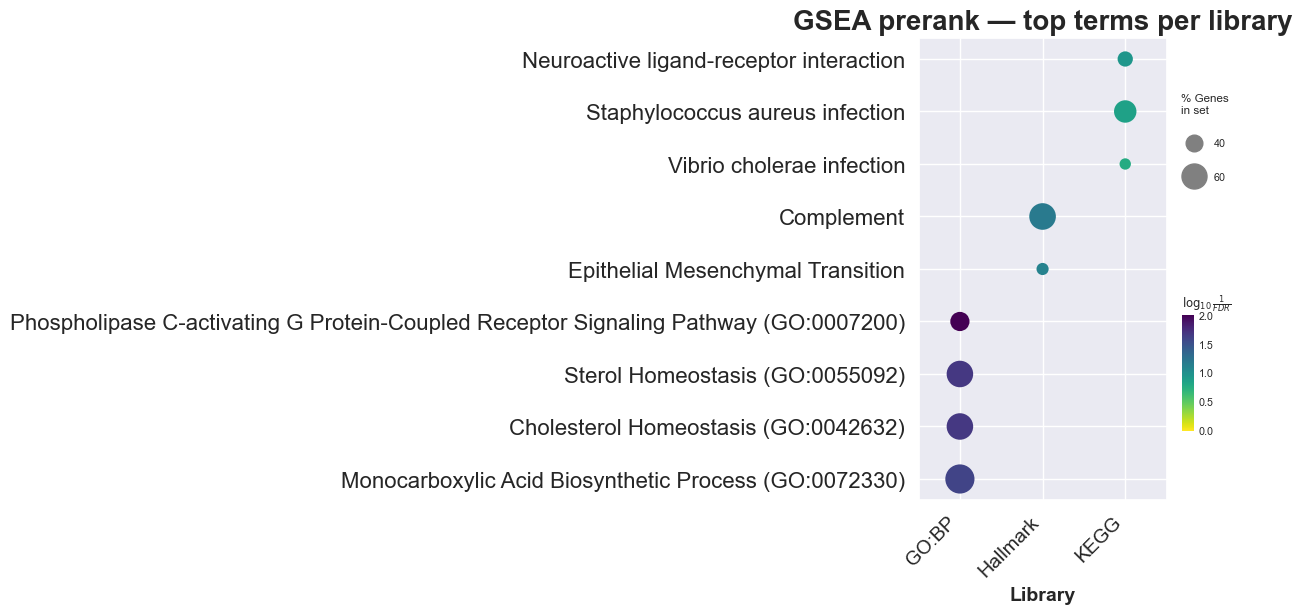

In [ ]:
def add_lib(res, lib):
    df = res.res2d.copy()
    df["Library"] = lib
    return df

plot_df = pd.concat([
    add_lib(res_h, "Hallmark"),
    add_lib(res_kegg, "KEGG"),
    add_lib(res_go, "GO:BP"),
], ignore_index=True)

plot_df = (plot_df.sort_values("FDR q-val")
           .groupby("Library", group_keys=False)
           .head(10))

dotplot(plot_df,
        x="Library",
        column="FDR q-val",
        cutoff=0.25,
        top_term=4,
        title="GSEA prerank — top terms per library",
        xticklabels_rot=45)
plt.show()

In [28]:
res_kegg.res2d.sort_values("FDR q-val", ascending=True).head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Neutrophil extracellular trap formation,0.712798,2.368928,0.0,0.0,0.0,16/28,15.95%,FCGR3A;C5AR1;HDAC4;SELPLG;FPR1;FCGR1A;TLR8;CLE...
3,prerank,Natural killer cell mediated cytotoxicity,0.70173,2.06467,0.0,0.002416,0.0055,11/18,15.95%,FCGR3A;FCER1G;LAT;ZAP70;BID;LCK;SH2D1B;PIK3CD;...
2,prerank,T cell receptor signaling pathway,0.701546,2.085641,0.0,0.002965,0.0045,12/19,15.07%,LAT;ZAP70;ITK;LCK;CD4;CD8A;PIK3CD;NFATC1;CTLA4...
5,prerank,Fc epsilon RI signaling pathway,0.767454,1.986927,0.0,0.007774,0.027,7/11,15.95%,FCER1G;LAT;PIK3CD;SYK;MAPK13;FCER1A;PRKCA
6,prerank,Osteoclast differentiation,0.614952,1.971825,0.000792,0.008235,0.0345,12/24,14.89%,FCGR3A;SIRPB1;LILRA5;LILRB3;OSCAR;LCK;FCGR1A;P...
4,prerank,Yersinia infection,0.598988,1.993248,0.0,0.00873,0.0245,13/28,15.07%,LAT;ZAP70;LCK;CD4;LIMK1;CD8A;PIK3CD;NFATC1;MYD...
1,prerank,Olfactory transduction,-0.580076,-2.112783,0.0,0.009038,0.016,19/29,19.18%,OR5P3;OR10P1;OR7G1;OR6S1;OR2T3;OR5J2;OR2C1;OR5...
7,prerank,Staphylococcus aureus infection,0.717897,1.939313,0.0,0.012141,0.0565,10/13,13.16%,FCGR3A;C5AR1;SELPLG;FPR1;FCGR1A;PTAFR;CFD;C3AR...
8,prerank,PD-L1 expression and PD-1 checkpoint pathway i...,0.617443,1.906369,0.000776,0.015647,0.081,11/21,14.89%,LAT;ZAP70;LCK;CD4;PIK3CD;NFATC1;CD274;MYD88;TL...
9,prerank,Primary immunodeficiency,0.719189,1.892064,0.001668,0.017715,0.1015,8/12,15.07%,TNFRSF13C;ZAP70;LCK;CD4;IL7R;CD8A;CD3E;CD8B


In [29]:
gene_list = list(common)

backgrounds = {"7k":[str(v) for v in unity]}

for name, background in backgrounds.items():

    enr_h = gp.enrichr(
        gene_list=gene_list,
        gene_sets="MSigDB_Hallmark_2020",
        organism="Human",
        outdir=f"enrichr_hallmark_topN_{name}",
        cutoff=0.25,
        background = background      
    )

    enr_kegg = gp.enrichr(
        gene_list=gene_list,
        gene_sets="KEGG_2021_Human",
        organism="Human",
        outdir=f"enrichr_kegg_topN_{name}",
        cutoff=0.25,
        background = background
    )

    enr_reactome = gp.enrichr(
        gene_list=gene_list,
        gene_sets="Reactome_2022",
        organism="Human",
        outdir=f"enrichr_reactome_topN_{name}",
        cutoff=0.25,
        background = background
    )

    enr_go = gp.enrichr(
        gene_list=gene_list,
        gene_sets="GO_Biological_Process_2023",
        organism="Human",
        outdir=f"enrichr_go_bp_topN_{name}",
        cutoff=0.25,
        background = background
    )

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gseapy/plot.py:756: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))


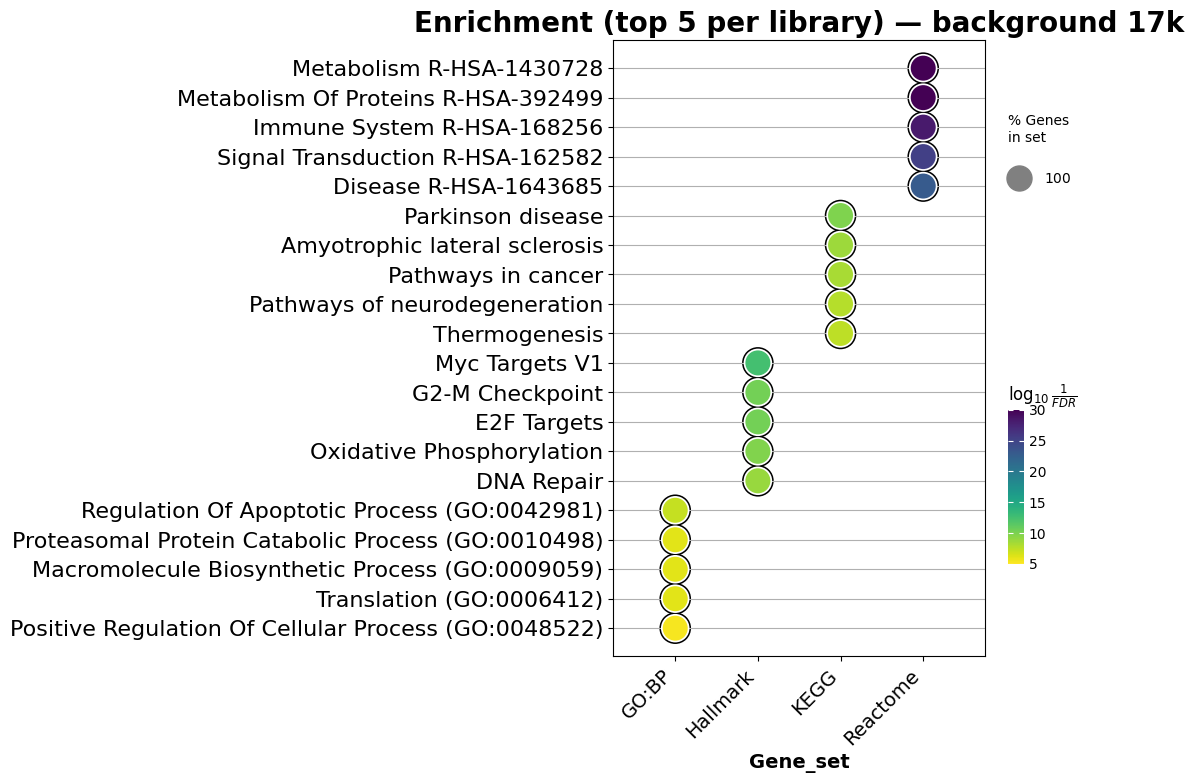

In [ ]:
import pandas as pd
import gseapy as gp
from gseapy import dotplot

gene_list = list(common)
backgrounds = {"17k": [str(v) for v in unity]}

for name, background in backgrounds.items():
    enr_h = gp.enrichr(
        gene_list=gene_list, gene_sets="MSigDB_Hallmark_2020", organism="Human",
        outdir=f"enrichr_hallmark_topN_{name}", cutoff=0.25, background=background
    )
    enr_kegg = gp.enrichr(
        gene_list=gene_list, gene_sets="KEGG_2021_Human", organism="Human",
        outdir=f"enrichr_kegg_topN_{name}", cutoff=0.25, background=background
    )
    enr_reactome = gp.enrichr(
        gene_list=gene_list, gene_sets="Reactome_2022", organism="Human",
        outdir=f"enrichr_reactome_topN_{name}", cutoff=0.25, background=background
    )
    enr_go = gp.enrichr(
        gene_list=gene_list, gene_sets="GO_Biological_Process_2023", organism="Human",
        outdir=f"enrichr_go_bp_topN_{name}", cutoff=0.25, background=background
    )

    def prep(res, lib_name):
        df = res.results.copy()
        df["Gene_set"] = lib_name
        return df

    plot_df = pd.concat([
        prep(enr_h, "Hallmark"),
        prep(enr_kegg, "KEGG"),
        prep(enr_reactome, "Reactome"),
        prep(enr_go, "GO:BP"),
    ], ignore_index=True)

    TOP_PER_LIB = 5
    plot_df = (plot_df
               .sort_values("Adjusted P-value", ascending=True)
               .groupby("Gene_set", group_keys=False)
               .head(TOP_PER_LIB))

    ax = dotplot(
        plot_df,
        column="Adjusted P-value",
        x="Gene_set",
        size=3,
        top_term=TOP_PER_LIB,
        figsize=(6, 8),
        title=f"Enrichment (top {TOP_PER_LIB} per library) — background {name}",
        xticklabels_rot=45,
        show_ring=True,
        marker="o",
    )

In [36]:
enr_h.res2d.sort_values("Adjusted P-value", ascending=True).head(10)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Myc Targets V1,6.048607e-15,3.024304e-13,0,0,4.070741,133.271768,HDDC2;SLC25A3;HSP90AB1;MCM7;RPLP0;RPL6;RRP9;CD...
1,MSigDB_Hallmark_2020,E2F Targets,2.048277e-12,4.464328e-11,0,0,3.531020,95.033945,CDKN1A;MCM7;SMC6;CKS1B;CDC20;PNN;MYBL2;LBR;TMP...
2,MSigDB_Hallmark_2020,G2-M Checkpoint,2.678597e-12,4.464328e-11,0,0,3.835266,102.193442,NUMA1;CCNF;SMC2;KIF15;CKS1B;CDC20;SNRPD1;PBK;M...
3,MSigDB_Hallmark_2020,Oxidative Phosphorylation,1.399200e-11,1.749000e-10,0,0,3.270111,81.728366,GPI;SLC25A3;MRPS11;COX4I1;MRPL34;COX6A1;COX7C;...
4,MSigDB_Hallmark_2020,DNA Repair,1.514264e-10,1.514264e-09,0,0,3.712640,83.946215,CDA;GTF2A2;TSG101;ARL6IP1;ELL;COX17;TYMS;SNAPC...
5,MSigDB_Hallmark_2020,mTORC1 Signaling,2.611063e-08,2.175886e-07,0,0,2.892534,50.506317,GPI;IDI1;CDKN1A;TOMM40;PSMD14;SHMT2;PSMD13;CCN...
6,MSigDB_Hallmark_2020,Allograft Rejection,6.204394e-08,4.431710e-07,0,0,2.864959,47.545203,ITK;IGSF6;CD80;CD3E;IL2RG;HIF1A;HDAC9;CTSS;ST8...
7,MSigDB_Hallmark_2020,Estrogen Response Late,6.050043e-07,3.781277e-06,0,0,2.770382,39.666418,MOCS2;SERPINA1;RNASEH2A;NXT1;ARL3;SNX10;AREG;P...
8,MSigDB_Hallmark_2020,Estrogen Response Early,1.332539e-06,7.402996e-06,0,0,2.701806,36.551180,NXT1;ARL3;ISG20L2;NADSYN1;AREG;TSKU;PAPSS2;AFF...
9,MSigDB_Hallmark_2020,Adipogenesis,1.971678e-06,9.858390e-06,0,0,2.608426,34.265917,RTN3;ECHS1;CD151;SOWAHC;MGST3;AK2;COX6A1;MYLK;...


## Metabolism genes

In [332]:
genes = [
    # Oncology genes
    "DPYD", "UGT1A1", "TPMT", "NUDT15",

    # Phase I
    "CYP3A4", "CYP3A5", "CYP2D6", "CYP2C9", "CYP2C19", "CYP2B6",
    "CYP1A2", "CYP2A6", "CYP2C8",
    "CES1", "CES2", "CDA", "DCK",

    # Phase II
    "UGT1A9", "UGT2B7",
    "SULT", "NAT1", "NAT2",
    "GSTM1", "GSTT1", "GSTP1",

    # Transporters
    "ABCB1", "ABCC1", "ABCC2", "ABCC3", "ABCG2",
    "SLCO1B1", "SLCO1B3",
    "SLC22A1", "SLC22A2",
    "SLC47A1", "SLC47A2",
]

In [211]:
sample_to_patient = dict(zip(clinical_sample['SAMPLE_ID'], clinical_sample['PATIENT_ID']))

rna_seq_metabolism_T = rna_seq.loc[rna_seq["Hugo_Symbol"].isin(genes)].set_index("Hugo_Symbol").drop("Entrez_Gene_Id", axis=1).T
rna_seq_metabolism_T['PATIENT_ID'] = rna_seq_metabolism_T.index.map(sample_to_patient)

rna_seq_metabolism_T = rna_seq_metabolism_T.merge(
    clinical_patient[['PATIENT_ID', 'OS_DAYS', 'OS_STATUS']], 
    on='PATIENT_ID', 
    how='left'
)

In [212]:
print("Before:", rna_seq_metabolism_T.shape, "unique PATIENT_IDs:", rna_seq_metabolism_T["PATIENT_ID"].nunique())

gene_cols = [c for c in rna_seq_metabolism_T.columns if c not in ("PATIENT_ID", "OS_DAYS", "OS_STATUS")]
rna_seq_metabolism_T["_sum_expr"] = rna_seq_metabolism_T[gene_cols].sum(axis=1)

idx = rna_seq_metabolism_T.groupby("PATIENT_ID")["_sum_expr"].idxmax()
rna_seq_metabolism_T = rna_seq_metabolism_T.loc[idx].drop(columns=["_sum_expr"]).reset_index(drop=True)

print("After:", rna_seq_metabolism_T.shape, "unique PATIENT_IDs:", rna_seq_metabolism_T["PATIENT_ID"].nunique())

Before: (154, 37) unique PATIENT_IDs: 154
After: (154, 37) unique PATIENT_IDs: 154


In [213]:
rna_seq_metabolism_T.dropna(axis=0, inplace=True)

In [195]:
df_train, df_test = train_test_split(rna_seq_metabolism_T, test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

In [196]:
cph = CoxPHFitter()
cph.fit(df_train.drop("PATIENT_ID", axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 110 total observations, 45 right-censored observations>

In [197]:
print(cph.score(df_train.drop("PATIENT_ID", axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop("PATIENT_ID", axis=1), scoring_method="concordance_index"))

0.7807091599831152
0.6130952380952381


In [198]:
cph.summary.sort_values(by="p", ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
UGT1A1,123.542826,4.507829e+53,35.785809,53.403929,193.681722,1.559666e+23,1.302876e+84,0.0,3.452285,0.000556,10.812992
CYP2C9,-34.993067,6.348979e-16,14.504796,-63.421944,-6.564190,2.858904e-28,1.409965e-03,0.0,-2.412517,0.015843,5.980029
SLC22A1,1.888041,6.606415e+00,0.837679,0.246220,3.529863,1.279181e+00,3.411928e+01,0.0,2.253895,0.024203,5.368682
ABCC1,-0.032717,9.678121e-01,0.016192,-0.064453,-0.000981,9.375798e-01,9.990192e-01,0.0,-2.020568,0.043325,4.528672
UGT1A9,-30.908447,3.772524e-14,16.464139,-63.177567,1.360673,3.650324e-28,3.898815e+00,0.0,-1.877319,0.060474,4.047533
TPMT,-0.261525,7.698766e-01,0.143930,-0.543623,0.020573,5.806407e-01,1.020786e+00,0.0,-1.817027,0.069213,3.852813
CYP2C8,0.305977,1.357951e+00,0.186717,-0.059981,0.671935,9.417822e-01,1.958022e+00,0.0,1.638722,0.101271,3.303705
CES2,0.142814,1.153515e+00,0.089371,-0.032350,0.317977,9.681674e-01,1.374345e+00,0.0,1.597987,0.110046,3.183823
UGT2B7,-54.590096,1.958045e-24,34.904763,-123.002174,13.821982,3.809209e-54,1.006493e+06,0.0,-1.563973,0.117824,3.085295


In [208]:
rna_and_clinical_metabolism = rna_seq_metabolism_T.join(clinical_sample.loc[:, ['PATIENT_ID', 'BONE_MARROW_SITE_OF_RELAPSE']].set_index('PATIENT_ID'), on='PATIENT_ID')

In [209]:
df_train, df_test = train_test_split(rna_and_clinical_metabolism, test_size=0.15, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

In [210]:
cph = CoxPHFitter()
cph.fit(df_train.drop("PATIENT_ID", axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 219 total observations, 88 right-censored observations>

In [211]:
print(cph.score(df_train.drop("PATIENT_ID", axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop("PATIENT_ID", axis=1), scoring_method="concordance_index"))

0.77542925734565
0.6332547169811321


In [212]:
cph.summary.sort_values(by="p", ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ABCC3,5.803004,3.312933e+02,1.267033,3.319665,8.286343,2.765107e+01,3.969294e+03,0.0,4.579994,0.000005,17.714369
SLC47A2,-147.702574,7.138175e-65,39.057328,-224.253531,-71.151617,4.054422e-98,1.256740e-31,0.0,-3.781687,0.000156,12.648300
BONE_MARROW_SITE_OF_RELAPSE,1.589513,4.901362e+00,0.444118,0.719058,2.459969,2.052498e+00,1.170444e+01,0.0,3.579033,0.000345,11.501667
NAT1,0.830589,2.294670e+00,0.249708,0.341170,1.320008,1.406592e+00,3.743452e+00,0.0,3.326239,0.000880,10.149775
SLC47A1,1.261346,3.530168e+00,0.389080,0.498763,2.023928,1.646683e+00,7.567995e+00,0.0,3.241867,0.001187,9.717864
CYP3A5,39.071840,9.304313e+16,12.064523,15.425810,62.717869,5.004308e+06,1.729914e+27,0.0,3.238573,0.001201,9.701197
GSTP1,0.006785,1.006808e+00,0.002105,0.002660,0.010911,1.002663e+00,1.010970e+00,0.0,3.223694,0.001265,9.626092
TPMT,-0.337263,7.137212e-01,0.106608,-0.546211,-0.128315,5.791402e-01,8.795763e-01,0.0,-3.163579,0.001558,9.325702
CYP2A6,52.977721,1.018432e+23,17.126884,19.409645,86.545797,2.688449e+08,3.857999e+37,0.0,3.093249,0.001980,8.980446


# First event

## Patient

In [164]:
relapsed = clinical_patient[clinical_patient["FIRST_EVENT"]=="Relapse"].copy()

In [165]:
relapsed["ALTERNATE_THERAPY_IND"] = relapsed["ALTERNATE_THERAPY"].notna().astype(int)

In [166]:
relapsed['CNS_STATUS_simplified'] = relapsed['CNS_STATUS'].str.extract(r'(\d+)', expand=False)
relapsed['CNS_STATUS_simplified'] = pd.to_numeric(relapsed['CNS_STATUS_simplified'], errors='coerce')

In [167]:
relapsed = relapsed.drop(["MRD_PERCENT_DAY_43", "MRD_PERCENT_DAY_43_SENSITIVITY", "MRD_END_CONSOLIDATION", "MRD_END_CONSOLIDATION_SENSITIVITY", "ALTERNATE_THERAPY_OTHER", "ALTERNATE_THERAPY", "BM_DAY_43", "KARYOTYPE", "OS_MONTHS", 'DAYS_TO_DEATH', "AGE", "CNS_STATUS", "PROTOCOL"], axis=1)

In [168]:
from sklearn.impute import KNNImputer

numeric_cols = relapsed.select_dtypes(include=[float, int, "number"]).columns.tolist()

if "MRD_PERCENT_DAY_8" not in numeric_cols:
    relapsed["MRD_PERCENT_DAY_8"] = pd.to_numeric(relapsed["MRD_PERCENT_DAY_8"], errors="coerce")
    numeric_cols = relapsed.select_dtypes(include=[float, int, "number"]).columns.tolist()

missing_before = relapsed["MRD_PERCENT_DAY_8"].isna().sum()
print(f"Missing before: {missing_before}")

if missing_before > 0:
    imputer = KNNImputer(n_neighbors=5)
    try:
        imputed_numeric = pd.DataFrame(
            imputer.fit_transform(relapsed[numeric_cols]),
            columns=numeric_cols,
            index=relapsed.index,
        )
        relapsed.loc[:, numeric_cols] = imputed_numeric
        missing_after = relapsed["MRD_PERCENT_DAY_8"].isna().sum()
        print(f"Missing after: {missing_after}")
    except Exception as e:
        print("Imputation failed:", e)
else:
    print("No missing values to impute")

print(relapsed[["PATIENT_ID", "MRD_PERCENT_DAY_8"]].head(10))

Missing before: 213
Missing after: 0
          PATIENT_ID  MRD_PERCENT_DAY_8
0   TARGET-10-PANBXW            0.94782
1   TARGET-10-PANCVR           12.71380
2   TARGET-10-PANDCF           13.37480
3   TARGET-10-PANDPX            0.17260
4   TARGET-10-PANDRS           12.61160
5   TARGET-10-PANDWE            1.74000
6   TARGET-10-PANDYD            3.25000
7   TARGET-10-PANGIF            1.53540
9   TARGET-10-PANJWJ            6.29880
10  TARGET-10-PANKAK           12.78080


In [174]:
relapsed_ohe = one_hot_encode_non_float(relapsed, exclude=['PATIENT_ID', 'OS_DAYS', 'OS_STATUS', 'DAYS_TO_EVENT', 'FIRST_EVENT'], drop_first=True, verbose=True)

Binary columns (single dummy will be created): ['SEX', 'ALTERNATE_THERAPY_IND']
Multi-category columns (one-hot encoded): ['RACE', 'ETHNICITY', 'TESTICULAR_INVOLVEMENT']


In [176]:
relapsed_ohe.FIRST_EVENT.replace({'Relapse':1, 'No Event':0}, inplace=True)

In [177]:
df_train, df_test = train_test_split(relapsed_ohe.drop(['MRD_PERCENT_DAY_8_SENSITIVITY', 'MRD_PERCENT_DAY_29_SENSITIVITY', 'RACE_Native Hawaiian or other Pacific Islander', 'TESTICULAR_INVOLVEMENT_1', 'TESTICULAR_INVOLVEMENT_NA'], axis=1), test_size=0.2, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

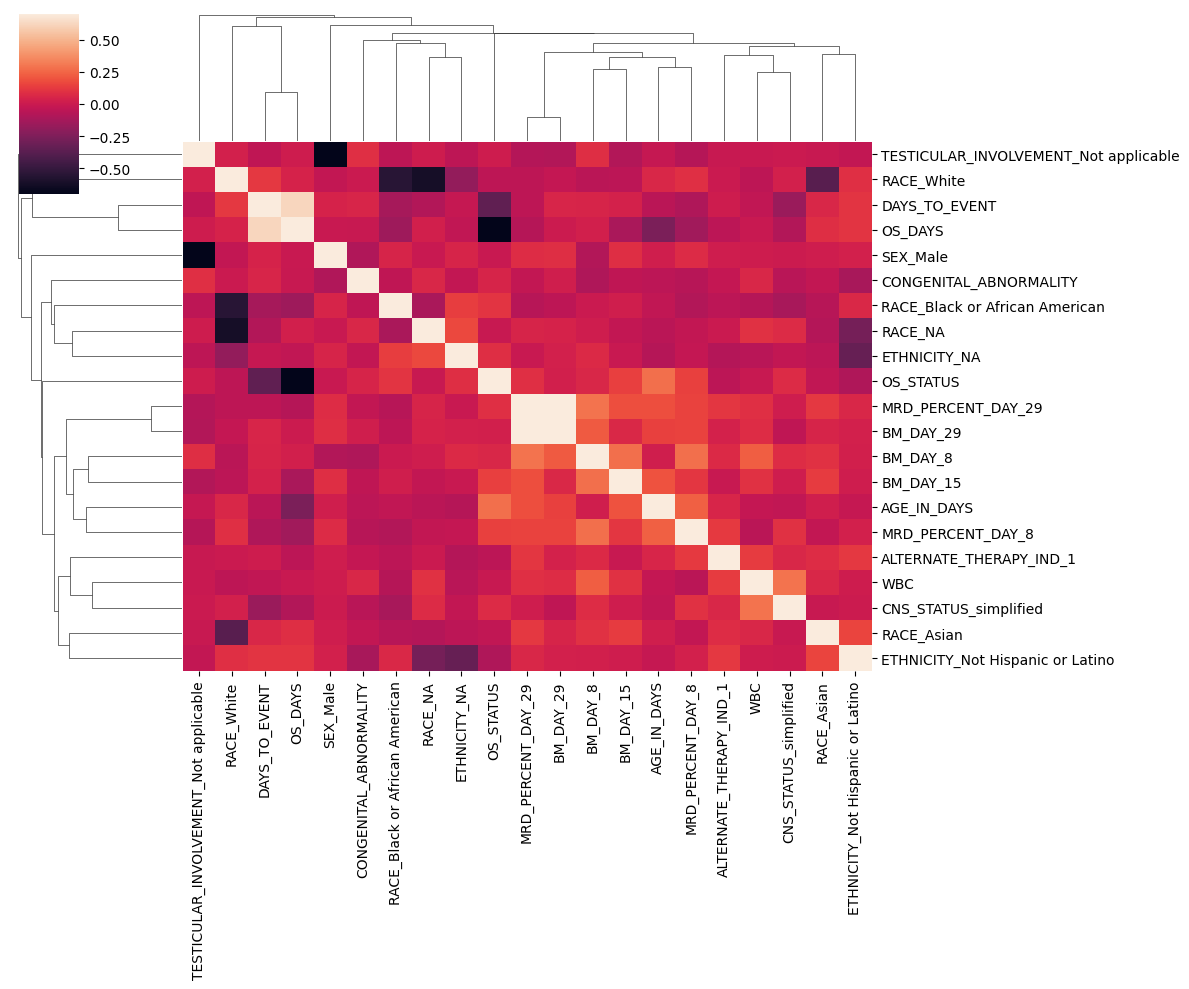

In [178]:
sns.clustermap(df_train.select_dtypes(include="number").drop("FIRST_EVENT", axis=1).corr(), figsize=(12, 10), vmin=-0.7, vmax=0.7)
plt.show()

In [179]:
def drop(df_train, df_test, df_val, columns):
    for i in columns:
        if i in df_train.columns:
            print(i)
            df_train.drop(columns=i, inplace=True)
            df_val.drop(columns=i, inplace=True)
            df_test.drop(columns=i, inplace=True)

In [181]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 160 to 126
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PATIENT_ID                             221 non-null    object 
 1   AGE_IN_DAYS                            221 non-null    float64
 2   WBC                                    221 non-null    float64
 3   MRD_PERCENT_DAY_8                      221 non-null    float64
 4   MRD_PERCENT_DAY_29                     221 non-null    float64
 5   FIRST_EVENT                            221 non-null    int64  
 6   DAYS_TO_EVENT                          221 non-null    float64
 7   OS_STATUS                              221 non-null    float64
 8   OS_DAYS                                221 non-null    float64
 9   BM_DAY_8                               221 non-null    float64
 10  BM_DAY_15                              221 non-null    float64
 11  BM_DAY_29

In [182]:
drop(df_train, df_test, df_val, ["MRD_PERCENT_DAY_29", "RACE_NA", "ETHNICITY_NA", 'RACE_Black or African American', 'TESTICULAR_INVOLVEMENT_Not applicable', 'TESTICULAR_INVOLVEMENT_NA'])

MRD_PERCENT_DAY_29
RACE_NA
ETHNICITY_NA
RACE_Black or African American
TESTICULAR_INVOLVEMENT_Not applicable


In [191]:
drop(relapsed_ohe, df_test, df_val, ["MRD_PERCENT_DAY_29", "RACE_NA", "ETHNICITY_NA", 'RACE_Black or African American', 'TESTICULAR_INVOLVEMENT_Not applicable', 'TESTICULAR_INVOLVEMENT_NA'])

MRD_PERCENT_DAY_29
RACE_NA
ETHNICITY_NA
RACE_Black or African American
TESTICULAR_INVOLVEMENT_Not applicable
TESTICULAR_INVOLVEMENT_NA


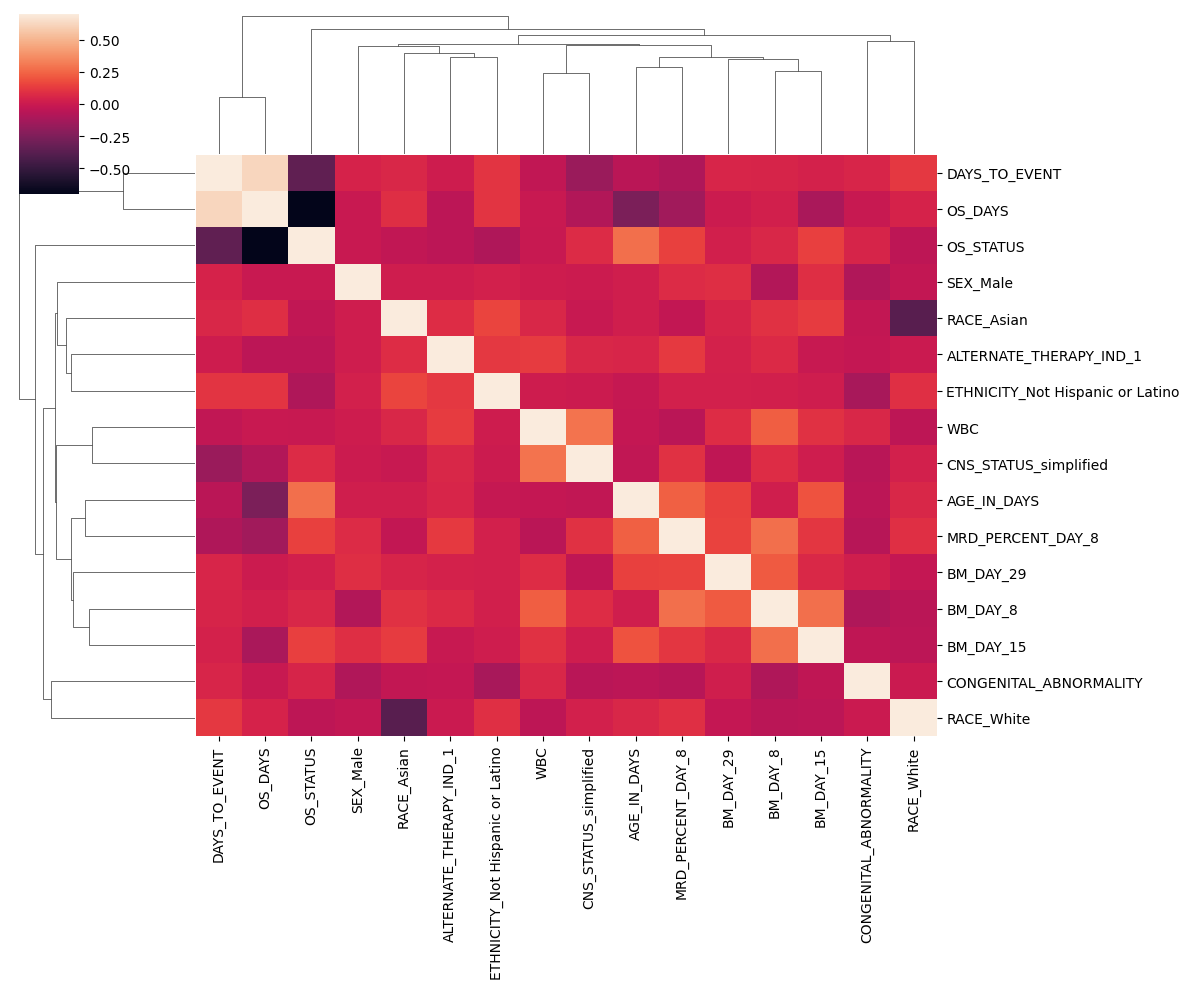

In [183]:
sns.clustermap(df_train.select_dtypes(include="number").drop("FIRST_EVENT", axis=1).corr(), figsize=(12, 10), vmin=-0.7, vmax=0.7)
plt.show()

In [184]:
cph = CoxPHFitter()
cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 221 total observations, 0 right-censored observations>

In [185]:
print(cph.score(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.5978350345735923
0.6296641791044776


In [186]:
cph.summary[cph.summary["p"]<0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
CNS_STATUS_simplified,0.356867,1.428846,0.160451,0.042389,0.671345,1.043300,1.956868,0.0,2.224149,0.026138,5.257685
RACE_White,-0.451722,0.636531,0.182185,-0.808798,-0.094647,0.445393,0.909694,0.0,-2.479472,0.013158,6.247950


In [153]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

    score = cph.score(df_val.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 19:33:09,629] A new study created in memory with name: no-name-4bf871bd-fe18-4f84-8dac-0cebc82a6e60
[I 2025-12-18 19:33:09,951] Trial 5 finished with value: 0.6059379217273954 and parameters: {'penalizer': 0.6502918525598684}. Best is trial 5 with value: 0.6059379217273954.
[I 2025-12-18 19:33:09,959] Trial 1 finished with value: 0.5802968960863698 and parameters: {'penalizer': 0.017224611027208576}. Best is trial 5 with value: 0.6059379217273954.
[I 2025-12-18 19:33:09,960] Trial 2 finished with value: 0.5843454790823212 and parameters: {'penalizer': 0.08169825230135491}. Best is trial 5 with value: 0.6059379217273954.
[I 2025-12-18 19:33:09,960] Trial 3 finished with value: 0.582995951417004 and parameters: {'penalizer': 0.028035930977802777}. Best is trial 5 with value: 0.6059379217273954.
[I 2025-12-18 19:33:09,967] Trial 6 finished with value: 0.5802968960863698 and parameters: {'penalizer': 0.01845659605625604}. Best is trial 5 with value: 0.6059379217273954.
[I 202

Best params: {'penalizer': 0.5397293057736178}
Best c-index: 0.6072874493927125


In [154]:
cph = CoxPHFitter(penalizer=0.5397293057736178)
cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 221 total observations, 0 right-censored observations>

In [155]:
print(cph.score(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.6077132038195587
0.6450559701492538


In [156]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
AGE_IN_DAYS,0.000005,1.000005,0.000027,-0.000048,0.000058,0.999952,1.000058,0.0,0.191630,0.848032,0.237810
WBC,0.000146,1.000146,0.000395,-0.000627,0.000920,0.999373,1.000920,0.0,0.370985,0.710649,0.492791
MRD_PERCENT_DAY_8,0.010362,1.010415,0.008480,-0.006259,0.026982,0.993760,1.027350,0.0,1.221873,0.221756,2.172956
MRD_PERCENT_DAY_29,0.011967,1.012039,0.015679,-0.018764,0.042698,0.981411,1.043623,0.0,0.763252,0.445313,1.167108
BM_DAY_8,-0.001599,0.998402,0.002039,-0.005595,0.002397,0.994421,1.002400,0.0,-0.784242,0.432898,1.207901
BM_DAY_15,-0.002864,0.997140,0.005445,-0.013536,0.007807,0.986556,1.007838,0.0,-0.526054,0.598851,0.739732
BM_DAY_29,-0.024955,0.975353,0.026687,-0.077261,0.027350,0.925649,1.027727,0.0,-0.935127,0.349723,1.515716
CONGENITAL_ABNORMALITY,-0.171543,0.842364,0.400750,-0.956998,0.613911,0.384044,1.847644,0.0,-0.428056,0.668610,0.580763
CNS_STATUS_simplified,0.225973,1.253541,0.124226,-0.017505,0.469451,0.982647,1.599115,0.0,1.819050,0.068904,3.859272


In [258]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

    score = cph.score(df_val.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 05:41:23,169] A new study created in memory with name: no-name-abd346e8-5d3c-4b78-ab54-88a9d62f52d0
[I 2025-12-18 05:41:23,457] Trial 1 finished with value: 0.5810344827586207 and parameters: {'penalizer': 7.561826969167959}. Best is trial 1 with value: 0.5810344827586207.
[I 2025-12-18 05:41:23,536] Trial 3 finished with value: 0.593103448275862 and parameters: {'penalizer': 0.22657389916971957}. Best is trial 3 with value: 0.593103448275862.
[I 2025-12-18 05:41:23,617] Trial 6 finished with value: 0.5896551724137931 and parameters: {'penalizer': 0.002803840240039639}. Best is trial 3 with value: 0.593103448275862.
[I 2025-12-18 05:41:23,683] Trial 4 finished with value: 0.5896551724137931 and parameters: {'penalizer': 0.0020577952698319804}. Best is trial 3 with value: 0.593103448275862.
[I 2025-12-18 05:41:23,686] Trial 0 finished with value: 0.5775862068965517 and parameters: {'penalizer': 0.04700799311641762}. Best is trial 3 with value: 0.593103448275862.
[I 2025-12

Best params: {'penalizer': 0.35135286683661987}
Best c-index: 0.6


In [261]:
cph = CoxPHFitter(penalizer=0.35135286683661987)
cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 221 total observations, 93 right-censored observations>

In [262]:
print(cph.score(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))

0.6604250490044362
0.6698645598194131


## Patient + sample

In [187]:
clnical_needed_for_relapsed = clinical_sample.loc[:, ['PATIENT_ID', 'BONE_MARROW_SITE_OF_RELAPSE', 'CNS_SITE_OF_RELAPSE', 'TESTES_SITE_OF_RELAPSE', 'OTHER_SITE_OF_RELAPSE']]

In [192]:
first_clinical = clnical_needed_for_relapsed.drop_duplicates(subset="PATIENT_ID", keep="first").set_index("PATIENT_ID")
relapsed_with_clinical = relapsed_ohe.join(first_clinical, on="PATIENT_ID")
relapsed_with_clinical #.head()

,PATIENT_ID,AGE_IN_DAYS,WBC,MRD_PERCENT_DAY_8,MRD_PERCENT_DAY_8_SENSITIVITY,MRD_PERCENT_DAY_29_SENSITIVITY,FIRST_EVENT,DAYS_TO_EVENT,OS_STATUS,OS_DAYS,...,ALTERNATE_THERAPY_IND_1,RACE_Asian,RACE_Native Hawaiian or other Pacific Islander,RACE_White,ETHNICITY_Not Hispanic or Latino,TESTICULAR_INVOLVEMENT_1,BONE_MARROW_SITE_OF_RELAPSE,CNS_SITE_OF_RELAPSE,TESTES_SITE_OF_RELAPSE,OTHER_SITE_OF_RELAPSE
0,TARGET-10-PANBXW,2872.0,117.0,0.94782,0.0082,0.0100,1,1764.0,1.0,3464.0,...,0,0,0,1,1,0,1.0,0.0,0.0,0.0
1,TARGET-10-PANCVR,2329.0,209.2,12.71380,0.0082,0.0100,1,285.0,1.0,473.0,...,0,0,0,1,0,0,1.0,1.0,0.0,1.0
2,TARGET-10-PANDCF,2683.0,250.7,13.37480,0.0082,0.0100,1,908.0,1.0,1069.0,...,0,0,0,1,0,0,1.0,0.0,0.0,0.0
3,TARGET-10-PANDPX,1393.0,65.3,0.17260,0.0064,0.0100,1,1961.0,0.0,3982.0,...,0,0,0,1,1,0,1.0,0.0,0.0,0.0
4,TARGET-10-PANDRS,6673.0,400.0,12.61160,0.0082,0.0100,1,978.0,1.0,1063.0,...,0,0,0,1,0,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,TARGET-10-PAPIDE,6245.0,463.0,0.79800,0.0100,0.0262,1,263.0,1.0,350.0,...,1,0,0,1,1,1,1.0,0.0,0.0,0.0
1540,TARGET-10-PAPIHY,5086.0,96.4,1.18600,0.0100,0.0100,1,914.0,1.0,1677.0,...,0,0,0,1,1,0,0.0,1.0,0.0,0.0
1541,TARGET-10-PAPIII,1412.0,52.3,1.00200,0.0100,0.0010,1,1244.0,0.0,1679.0,...,0,0,0,1,0,0,1.0,0.0,0.0,0.0
1542,TARGET-10-PAPIJF,5052.0,31.1,0.93200,0.0100,0.0010,1,349.0,1.0,2100.0,...,0,0,0,1,1,0,0.0,1.0,0.0,0.0


In [223]:
df_train, df_test = train_test_split(relapsed_with_clinical.drop(['MRD_PERCENT_DAY_8_SENSITIVITY', 'MRD_PERCENT_DAY_29_SENSITIVITY', 'RACE_Native Hawaiian or other Pacific Islander', 'TESTICULAR_INVOLVEMENT_1'], axis=1), test_size=0.2, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

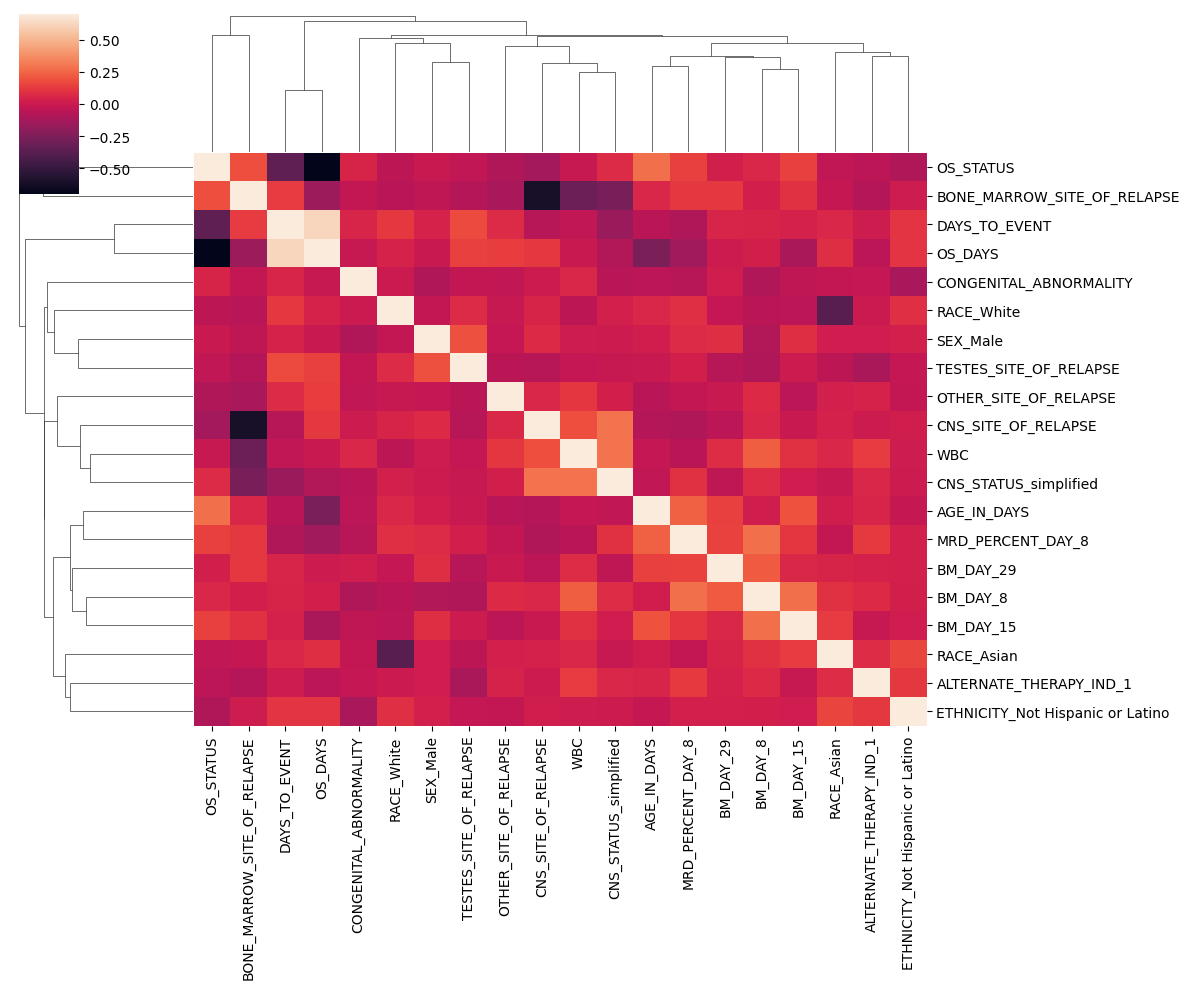

In [194]:
sns.clustermap(df_train.select_dtypes(include="number").drop("FIRST_EVENT", axis=1).corr(), figsize=(12, 10), vmin=-0.7, vmax=0.7)
plt.show()

In [195]:
cph = CoxPHFitter()
cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 221 total observations, 0 right-censored observations>

In [196]:
print(cph.score(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.6254527494237735
0.605410447761194


In [197]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

    score = cph.score(df_val.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 20:38:42,117] A new study created in memory with name: no-name-ba7b577a-5c5b-48e1-a34a-871a947fe63c
[I 2025-12-18 20:38:42,424] Trial 0 finished with value: 0.5924426450742241 and parameters: {'penalizer': 0.15979569460438947}. Best is trial 0 with value: 0.5924426450742241.
[I 2025-12-18 20:38:42,436] Trial 1 finished with value: 0.5789473684210527 and parameters: {'penalizer': 0.5029736109529014}. Best is trial 0 with value: 0.5924426450742241.
[I 2025-12-18 20:38:42,500] Trial 3 finished with value: 0.5883940620782726 and parameters: {'penalizer': 1.8400449163201604}. Best is trial 0 with value: 0.5924426450742241.
[I 2025-12-18 20:38:42,511] Trial 7 finished with value: 0.5910931174089069 and parameters: {'penalizer': 0.047838722282210616}. Best is trial 0 with value: 0.5924426450742241.
[I 2025-12-18 20:38:42,537] Trial 6 finished with value: 0.5937921727395412 and parameters: {'penalizer': 0.00951587050182579}. Best is trial 6 with value: 0.5937921727395412.
[I 2025

Best params: {'penalizer': 0.001003732782488378}
Best c-index: 0.5991902834008097


In [198]:
cph = CoxPHFitter(penalizer=0.001003732782488378)
cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 221 total observations, 0 right-censored observations>

In [199]:
print(cph.score(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.6256173855778729
0.6058768656716418


In [270]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

    score = cph.score(df_val.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 05:44:32,266] A new study created in memory with name: no-name-c9876be3-e8f6-4060-86e3-f9cc0cf6e370
[I 2025-12-18 05:44:32,645] Trial 1 finished with value: 0.6586206896551724 and parameters: {'penalizer': 7.743312402775751}. Best is trial 1 with value: 0.6586206896551724.
[I 2025-12-18 05:44:32,681] Trial 2 finished with value: 0.6586206896551724 and parameters: {'penalizer': 2.2001905125498413}. Best is trial 1 with value: 0.6586206896551724.
[I 2025-12-18 05:44:32,731] Trial 7 finished with value: 0.6551724137931034 and parameters: {'penalizer': 0.39232284886300245}. Best is trial 1 with value: 0.6586206896551724.
[I 2025-12-18 05:44:32,931] Trial 8 finished with value: 0.6603448275862069 and parameters: {'penalizer': 0.6987403719620201}. Best is trial 8 with value: 0.6603448275862069.
[I 2025-12-18 05:44:32,953] Trial 5 finished with value: 0.65 and parameters: {'penalizer': 0.003630602306193839}. Best is trial 8 with value: 0.6603448275862069.
[I 2025-12-18 05:44:33,

Best params: {'penalizer': 0.34586511479217613}
Best c-index: 0.6620689655172414


In [224]:
cph = CoxPHFitter()
cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 221 total observations, 93 right-censored observations>

In [225]:
print(cph.score(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))

0.643350871763128
0.6743792325056434


## RNA seq

In [288]:
relapsed_rna_clinical = relapsed_with_clinical.join(rna_seq_metabolism_T.set_index("PATIENT_ID").drop(columns=["OS_DAYS", "OS_STATUS"]), on="PATIENT_ID").dropna(axis=0)

In [289]:
available_genes = [g for g in genes if g in relapsed_rna_clinical.columns]
relapsed_rna = relapsed_rna_clinical.loc[:, available_genes + ['OS_DAYS', 'OS_STATUS', "DAYS_TO_EVENT", "FIRST_EVENT"]]

In [290]:
df_train, df_test = train_test_split(relapsed_rna, test_size=0.2, shuffle=True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle=True, random_state=42)

In [291]:
cph = CoxPHFitter()
cph.fit(df_train.drop(["OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>

In [292]:
print(cph.score(df_train.drop(["OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.7652091254752852
0.6159420289855072


In [295]:
cph.summary[cph.summary["p"]<0.05].index.tolist()

['UGT1A1', 'NUDT15', 'CYP2C9', 'CYP2C19', 'CYP2C8', 'CES1', 'ABCC3']

In [293]:
stat_sign_rna_only = cph.summary[cph.summary["p"]<0.05].index.to_list()

In [ ]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    train_cols_to_drop = [col for col in ["PATIENT_ID", "OS_DAYS", "OS_STATUS"] if col in df_train.columns]
    val_cols_to_drop = [col for col in ["PATIENT_ID", "OS_DAYS", "OS_STATUS"] if col in df_val.columns]
    
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(train_cols_to_drop, axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

    score = cph.score(df_val.drop(val_cols_to_drop, axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 05:46:09,756] A new study created in memory with name: no-name-771d8482-dd0b-421a-b289-8c9de9fe2fb8
[I 2025-12-18 05:46:10,066] Trial 1 finished with value: 0.5523809523809524 and parameters: {'penalizer': 2.9752228326302754}. Best is trial 1 with value: 0.5523809523809524.
[I 2025-12-18 05:46:10,071] Trial 6 finished with value: 0.5619047619047619 and parameters: {'penalizer': 2.611181668793573}. Best is trial 6 with value: 0.5619047619047619.
[I 2025-12-18 05:46:10,136] Trial 4 finished with value: 0.6761904761904762 and parameters: {'penalizer': 0.3960354013825776}. Best is trial 4 with value: 0.6761904761904762.
[I 2025-12-18 05:46:10,317] Trial 5 finished with value: 0.6666666666666666 and parameters: {'penalizer': 0.008331474729865524}. Best is trial 4 with value: 0.6761904761904762.
[I 2025-12-18 05:46:10,414] Trial 0 finished with value: 0.7238095238095238 and parameters: {'penalizer': 0.11514642387906426}. Best is trial 0 with value: 0.7238095238095238.
[I 2025-1

Best params: {'penalizer': 0.025151906191461473}
Best c-index: 0.7904761904761904


In [255]:
cph = CoxPHFitter(penalizer=0.025151906191461473)
cph.fit(df_train.drop(["OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>

In [256]:
print(cph.score(df_train.drop(["OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.7392268694550064
0.6413043478260869


In [ ]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    train_cols_to_drop = [col for col in ["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"] if col in df_train.columns]
    val_cols_to_drop = [col for col in ["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"] if col in df_val.columns]
    
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(train_cols_to_drop, axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

    score = cph.score(df_val.drop(val_cols_to_drop, axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 05:48:30,073] A new study created in memory with name: no-name-dc9aa545-c93f-4b9c-835e-7f0deb73ccb5
[I 2025-12-18 05:48:30,354] Trial 1 finished with value: 0.6888888888888889 and parameters: {'penalizer': 3.268156614459047}. Best is trial 1 with value: 0.6888888888888889.
[I 2025-12-18 05:48:30,382] Trial 3 finished with value: 0.6777777777777778 and parameters: {'penalizer': 2.42507118146155}. Best is trial 1 with value: 0.6888888888888889.
[I 2025-12-18 05:48:30,402] Trial 6 finished with value: 0.6888888888888889 and parameters: {'penalizer': 2.3334952293596194}. Best is trial 1 with value: 0.6888888888888889.
[I 2025-12-18 05:48:30,556] Trial 8 finished with value: 0.7 and parameters: {'penalizer': 1.4014906644588774}. Best is trial 8 with value: 0.7.
[I 2025-12-18 05:48:30,587] Trial 4 finished with value: 0.6111111111111112 and parameters: {'penalizer': 0.2148596686418153}. Best is trial 8 with value: 0.7.
[I 2025-12-18 05:48:30,637] Trial 10 finished with value: 0

Best params: {'penalizer': 1.4014906644588774}
Best c-index: 0.7


In [257]:
cph = CoxPHFitter()
cph.fit(df_train.drop([ "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 80 total observations, 27 right-censored observations>

In [258]:
print(cph.score(df_train.drop(["DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))

0.7853712596970817
0.60546875


In [259]:
cph.summary[cph.summary["p"]<0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,


## RNA seq + clinical

In [296]:
df_train, df_test = train_test_split(relapsed_rna_clinical.drop(['MRD_PERCENT_DAY_8_SENSITIVITY', 'MRD_PERCENT_DAY_29_SENSITIVITY', 'RACE_Native Hawaiian or other Pacific Islander', 'TESTICULAR_INVOLVEMENT_1'], axis=1), test_size=0.2, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True, random_state=42)

In [236]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

    score = cph.score(df_val.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 20:49:46,814] A new study created in memory with name: no-name-61f36423-14aa-467d-8507-e7d4eb26aebe
[I 2025-12-18 20:49:47,319] Trial 4 finished with value: 0.7403846153846154 and parameters: {'penalizer': 0.6494964602094101}. Best is trial 4 with value: 0.7403846153846154.
[I 2025-12-18 20:49:47,459] Trial 3 finished with value: 0.6346153846153846 and parameters: {'penalizer': 0.03159873887720899}. Best is trial 4 with value: 0.7403846153846154.
[I 2025-12-18 20:49:47,509] Trial 2 finished with value: 0.6442307692307693 and parameters: {'penalizer': 0.03620702357226352}. Best is trial 4 with value: 0.7403846153846154.
[I 2025-12-18 20:49:47,552] Trial 0 finished with value: 0.6153846153846154 and parameters: {'penalizer': 0.0017575625699889142}. Best is trial 4 with value: 0.7403846153846154.
[I 2025-12-18 20:49:47,644] Trial 8 finished with value: 0.75 and parameters: {'penalizer': 2.4922597343346244}. Best is trial 8 with value: 0.75.
[I 2025-12-18 20:49:47,814] Trial 

Best params: {'penalizer': 1.1751939861354213}
Best c-index: 0.7596153846153846


In [298]:
cph = CoxPHFitter()
cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>

In [241]:
print(cph.score(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.8016476552598225
0.6594202898550725


In [242]:
cph.summary[cph.summary["p"]<0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
CES1,1.042459,2.836181,0.523954,0.015528,2.069389,1.015649,7.919983,0.0,1.9896,0.046635,4.422444


In [304]:
cph = CoxPHFitter(penalizer=1.1751939861354213)
cph.fit(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), duration_col="DAYS_TO_EVENT", event_col="FIRST_EVENT")

<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>

In [305]:
print(cph.score(df_train.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "OS_DAYS", "OS_STATUS"], axis=1), scoring_method="concordance_index"))

0.7290874524714829
0.6195652173913043


In [306]:
cph.summary[cph.summary["p"]<0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,


In [243]:
def objective(trial):
    penalizer = trial.suggest_float("penalizer", 1e-3, 10.0, log=True)

    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

    score = cph.score(df_val.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

print("Best params:", study.best_params)
print("Best c-index:", study.best_value)

[I 2025-12-18 20:52:26,047] A new study created in memory with name: no-name-fee3afa9-5a1c-4116-9065-b16664d3c88a
[I 2025-12-18 20:52:26,410] Trial 2 finished with value: 0.75 and parameters: {'penalizer': 0.9975641027371189}. Best is trial 2 with value: 0.75.
[I 2025-12-18 20:52:26,445] Trial 6 finished with value: 0.75 and parameters: {'penalizer': 4.931860291708322}. Best is trial 2 with value: 0.75.
[I 2025-12-18 20:52:26,501] Trial 0 finished with value: 0.75 and parameters: {'penalizer': 1.4403464593576405}. Best is trial 2 with value: 0.75.
[I 2025-12-18 20:52:26,563] Trial 3 finished with value: 0.75 and parameters: {'penalizer': 0.44836888507044576}. Best is trial 2 with value: 0.75.
[I 2025-12-18 20:52:26,628] Trial 7 finished with value: 0.625 and parameters: {'penalizer': 0.06380067160566749}. Best is trial 2 with value: 0.75.
[I 2025-12-18 20:52:26,634] Trial 5 finished with value: 0.625 and parameters: {'penalizer': 0.05998624362364264}. Best is trial 2 with value: 0.75.


Best params: {'penalizer': 9.473573535122156}
Best c-index: 0.7613636363636364


In [308]:
cph = CoxPHFitter(penalizer=9.473573535122156)
cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 80 total observations, 27 right-censored observations>

In [309]:
print(cph.score(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))

0.7380864425563354
0.62109375


In [311]:
cph.summary[cph.summary["p"]<0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,


In [312]:
cph = CoxPHFitter()
cph.fit(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), duration_col="OS_DAYS", event_col="OS_STATUS")

<lifelines.CoxPHFitter: fitted with 80 total observations, 27 right-censored observations>

In [313]:
print(cph.score(df_train.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))
print(cph.score(df_test.drop(["PATIENT_ID", "DAYS_TO_EVENT", "FIRST_EVENT"], axis=1), scoring_method="concordance_index"))

0.828592537864795
0.66015625


In [314]:
cph.summary[cph.summary["p"]<0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
